In [1]:
import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')  
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

<Client: 'tcp://203.247.189.224:37807' processes=5 threads=90, memory=419.10 GiB>

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp
import xcesm

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_preprocessing import CESM2_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

In [26]:
cfg_var_DIC_trop=CESM2_config()
cfg_var_DIC_trop.year_s=1955
cfg_var_DIC_trop.year_e=2020
cfg_var_DIC_trop.setvar('DIC')

cfg_var_TEMP=CESM2_config()
cfg_var_TEMP.year_s=1955
cfg_var_TEMP.year_e=2020
cfg_var_TEMP.setvar('TEMP')

start_date = cftime.DatetimeNoLeap(cfg_var_DIC_trop.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_DIC_trop.year_e+1, 1, 1)

ds_grid = pop_tools.get_grid('POP_gx1v7')

mask_pacific = ds_grid.REGION_MASK.where(ds_grid.REGION_MASK == 2)
mask_pacific=mask_pacific/2




In [65]:
exceptcv2=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_DIC_trop.var, cfg_var_DIC_trop_ALT.var]

def process_coords_DIC_trop(ds, sd, ed, mask_pacific, drop=True, except_coord_vars=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_DIC_trop.var]):
    import xcesm 
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        ds = ds* mask_pacific
        ds_rgd=ds.DIC.utils.regrid()
        ds_rgd = ds_rgd.sel(lat=slice(-20,11))
        ds_rgd = ds_rgd.where((ds_rgd.lon >= -50) | (ds_rgd.lon <= -50), drop=True).sum(dim='lon')/cell_area_2d.sum(dim='lon')

        R = 6371e3  # Earth radius (m)
        deg2rad = np.pi / 180
        lat_radians = ds_rgd.lat * deg2rad
        cell_area_1d = R**2 * deg2rad * deg2rad * np.cos(lat_radians)
        cell_area_2d = cell_area_1d.broadcast_like(ds_rgd)
        mask_area=ds_rgd / ds_rgd
        cell_area_2d=cell_area_2d*mask_area
        ds_rgd = ds_rgd * cell_area_2d
        ds_rgd =ds_rgd .sum(dim='lon')/cell_area_2d.sum(dim='lon')
       
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)

def process_coords_DIC_ALT_trop(ds, sd, ed, mask_pacific, drop=True, except_coord_vars=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_DIC_trop_ALT.var]):
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        ds = ds* mask_pacific
        ds_rgd=ds.DIC_ALT_CO2.utils.regrid()
        ds_rgd = ds_rgd.sel(lat=slice(-20,11))
        ds_rgd = ds_rgd.where((ds_rgd.lon >= -50) | (ds_rgd.lon <= -50), drop=True).sum(dim='lon')/cell_area_2d.sum(dim='lon')

        R = 6371e3  # Earth radius (m)
        deg2rad = np.pi / 180
        lat_radians = ds_rgd.lat * deg2rad
        cell_area_1d = R**2 * deg2rad * deg2rad * np.cos(lat_radians)
        cell_area_2d = cell_area_1d.broadcast_like(ds_rgd)
        mask_area=ds_rgd / ds_rgd
        cell_area_2d=cell_area_2d*mask_area
        ds_rgd = ds_rgd * cell_area_2d
        ds_rgd =ds_rgd .sum(dim='lon')/cell_area_2d.sum(dim='lon')
       
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)


def process_coords_TEMP(ds, sd, ed, mask_pacific, drop=True, except_coord_vars=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', 'TEMP']):
    import xcesm 
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        ds = ds* mask_pacific
        ds_rgd=ds.TEMP.utils.regrid()
        ds_rgd = ds_rgd.sel(lat=slice(-20,11))
        ds_rgd = ds_rgd.where((ds_rgd.lon >= -50) | (ds_rgd.lon <= -50), drop=True).sum(dim='lon')/cell_area_2d.sum(dim='lon')

        R = 6371e3  # Earth radius (m)
        deg2rad = np.pi / 180
        lat_radians = ds_rgd.lat * deg2rad
        cell_area_1d = R**2 * deg2rad * deg2rad * np.cos(lat_radians)
        cell_area_2d = cell_area_1d.broadcast_like(ds_rgd)
        mask_area=ds_rgd / ds_rgd
        cell_area_2d=cell_area_2d*mask_area
        ds_rgd = ds_rgd * cell_area_2d
        ds_rgd =ds_rgd .sum(dim='lon')/cell_area_2d.sum(dim='lon')
       
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)

In [35]:
# DIC_trop

start_time = time.time()

cfg_var_DIC_trop.LE_path_load(cfg_var_DIC_trop.var)
cfg_var_DIC_trop.LE_ds = xr.open_mfdataset(cfg_var_DIC_trop.LE_file_list[0][11:13], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC_trop.LE_ensembles[11:13]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_trop(ds, start_date, end_date, mask_pacific),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_trop.LE_ds = cfg_var_DIC_trop.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_DIC_trop.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_trop.LE_ds.time))
cfg_var_DIC_trop.LE_ds = cfg_var_DIC_trop.LE_ds.assign_coords(time=new_time)


cfg_var_DIC_trop.ADA_path_load(cfg_var_DIC_trop.var)
cfg_var_DIC_trop.ADA_ds = xr.open_mfdataset(cfg_var_DIC_trop.ADA_file_list[0][4:6], 
                       chunks={'time': 2}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_DIC_trop.ADA_ensembles[4:6]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_trop(ds, start_date, end_date, mask_pacific),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_trop.ADA_ds = cfg_var_DIC_trop.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_DIC_trop.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_trop.ADA_ds.time))
cfg_var_DIC_trop.ADA_ds = cfg_var_DIC_trop.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading DIC_trop: ' + str(elapsed_time))

elasped time for reading DIC_trop: 299.4578800201416


In [67]:
# DIC_ALT_trop

start_time = time.time()

cfg_var_DIC_ALT_trop=CESM2_config()
cfg_var_DIC_ALT_trop.year_s=1955
cfg_var_DIC_ALT_trop.year_e=2020
cfg_var_DIC_ALT_trop.setvar('DIC_ALT_CO2')

cfg_var_DIC_ALT_trop.LE_path_load(cfg_var_DIC_ALT_trop.var)
cfg_var_DIC_ALT_trop.LE_ds = xr.open_mfdataset(cfg_var_DIC_ALT_trop.LE_file_list[0][11:13], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC_ALT_trop.LE_ensembles[11:13]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_ALT_trop(ds, start_date, end_date, mask_pacific),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_ALT_trop.LE_ds = cfg_var_DIC_ALT_trop.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_DIC_ALT_trop.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_ALT_trop.LE_ds.time))
cfg_var_DIC_ALT_trop.LE_ds = cfg_var_DIC_ALT_trop.LE_ds.assign_coords(time=new_time)


cfg_var_DIC_ALT_trop.ADA_path_load(cfg_var_DIC_ALT_trop.var)
cfg_var_DIC_ALT_trop.ADA_ds = xr.open_mfdataset(cfg_var_DIC_ALT_trop.ADA_file_list[0][4:6], 
                       chunks={'time': 2}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_DIC_ALT_trop.ADA_ensembles[4:6]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_ALT_trop(ds, start_date, end_date, mask_pacific),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_ALT_trop.ADA_ds = cfg_var_DIC_ALT_trop.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_DIC_ALT_trop.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_ALT_trop.ADA_ds.time))
cfg_var_DIC_ALT_trop.ADA_ds = cfg_var_DIC_ALT_trop.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading DIC_ALT_trop: ' + str(elapsed_time))

elasped time for reading DIC_ALT_trop: 311.11344933509827


In [28]:
# TEMP

start_time = time.time()

cfg_var_TEMP.LE_path_load(cfg_var_TEMP.var)
cfg_var_TEMP.LE_ds = xr.open_mfdataset(cfg_var_TEMP.LE_file_list[0][11:13], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP.LE_ensembles[11:13]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_TEMP(ds, start_date, end_date, mask_pacific),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_TEMP.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.LE_ds.time))
cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.assign_coords(time=new_time)


cfg_var_TEMP.ADA_path_load(cfg_var_TEMP.var)
cfg_var_TEMP.ADA_ds = xr.open_mfdataset(cfg_var_TEMP.ADA_file_list[0][4:6], 
                       chunks={'time': 2}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_TEMP.ADA_ensembles[4:6]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_TEMP(ds, start_date, end_date, mask_pacific),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TEMP.ADA_ds = cfg_var_TEMP.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_TEMP.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.ADA_ds.time))
cfg_var_TEMP.ADA_ds = cfg_var_TEMP.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading TEMP: ' + str(elapsed_time))

elasped time for reading TEMP: 308.837881565094


In [ ]:
# # read WDA

# import re

# start_time = time.time()


# VAR='FG_CO2'
# comp='ocn'
# WDA_rootdir = '/mnt/lustre/proj/earth.system.predictability/ATM_TEST/EXP_ATM/archive'
# scenarios = r'\.(BHISTsmbb|BSSP370smbb)\.'
# command='ls ' + WDA_rootdir + '| grep BHISTsmbb | cut -d ''.'' -f 5-7'
# WDA_members_raw = subprocess.check_output(command, shell=True, text=True)
# WDA_members= [entry for entry in WDA_members_raw.split('\n') if entry]
# WDA_ensembles = [ens for ens in range(len(WDA_members))]
# WDA_file_list=[]
# # for var in VAR :
# WDA_ens_files=[]
# for member in WDA_members :
#     WDA_files=[]    
#     # command='ls ' + WDA_rootdir + '/*' + member + '*/' + comp + '/proc/tseries/' + tfreq + '| grep .' + var + '.'
#     command='ls ' + WDA_rootdir + '/*' + member + '*/' + comp + '/hist/*.' + 'pop.h.' + '????-??.nc' 
#     # print(command)
#     WDA_files_raw = subprocess.check_output(command, shell=True, text=True)
#     WDA_files= [entry for entry in WDA_files_raw.split('\n') if entry]
#     WDA_files = sorted(WDA_files)
#     # Filter the files based on your criteria
#     WDA_filtered_files = []
#     for fname in WDA_files:
#         # print(fname)  # Debugging: print each file name
#         match2 = re.search(r'\.(\d{4})-', fname)
#         if match2:
#             year2 = int(match2.group(1))
#             if year2 >= 1955 and year2 <= 2020:
#                 scenario=re.search(scenarios, fname).group(1)
#                 fpath = fname
#                 WDA_filtered_files.append(fpath)
#     WDA_ens_files.append(WDA_filtered_files)
# WDA_file_list.append(WDA_ens_files) 
# # for i in range(len(VAR)):
# #     print(i,VAR[i],len(WDA_file_list[i]),len(WDA_file_list[i][-1]))
# print(VAR,len(WDA_file_list),len(WDA_file_list[-1]))

# WDA_ds = xr.open_mfdataset(WDA_file_list[0][0],  
#                            chunks={'time': 2},  
#                            combine='nested', 
#                            concat_dim=[[*WDA_ensembles], 'time'], 
#                            parallel='False',  
#                            preprocess=lambda ds: process_coords_DIC_trop(ds, start_date, end_date, mask_pacific),
#                            decode_cf=True, 
#                            decode_times=True)

# end_time = time.time()
# elapsed_time = end_time - start_time

# WDA_ds = WDA_ds.rename_dims({'concat_dim': 'ensemble'})
# WDA_ds = WDA_ds.rename({'concat_dim': 'ensemble'})

# end_time = time.time()
# elapsed_time = end_time - start_time
# print('elasped time for reading WDA: ' + str(elapsed_time))


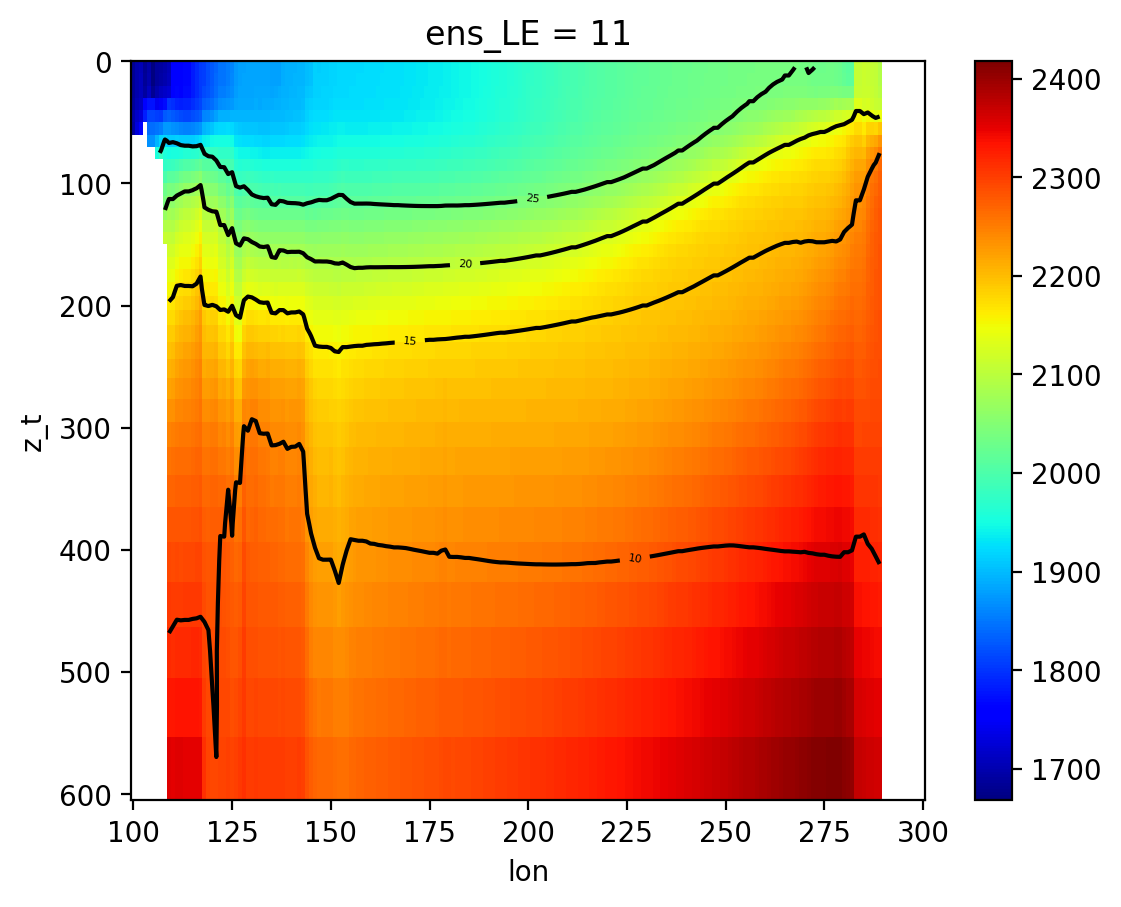

In [50]:
cmap='jet'

data_array=cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

fig, axes = plt.subplots(nrows=1, ncols=1, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=False)
contour_levels = [5, 10, 15, 20, 25]

# plt1=data_array.plot.pcolormesh(x='lon', y='z_t', ax=axes, cmap= cmap, add_colorbar=True)
plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes, cmap= cmap, add_colorbar=True)

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes, colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes.clabel(cs, inline=True, inline_spacing=8, fontsize=4)

axes.invert_yaxis()

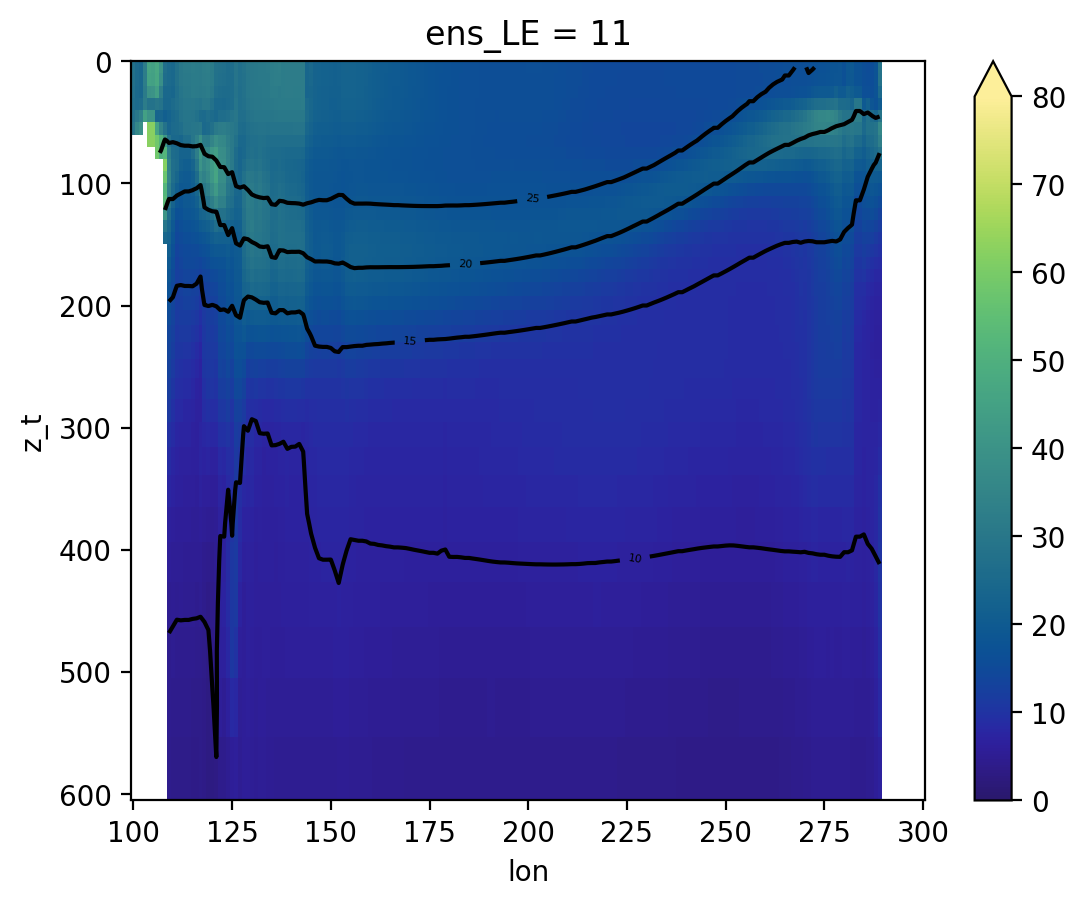

In [63]:
cmap=cmocean.cm.haline

data_array=cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

fig, axes = plt.subplots(nrows=1, ncols=1, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=False)
contour_levels = [5, 10, 15, 20, 25]

# plt1=data_array.plot.pcolormesh(x='lon', y='z_t', ax=axes, cmap= cmap, add_colorbar=True)
plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes, cmap= cmap, add_colorbar=True, 
                                  vmin=0, vmax=80, extend='max')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes, colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes.clabel(cs, inline=True, inline_spacing=8, fontsize=4)

axes.invert_yaxis()

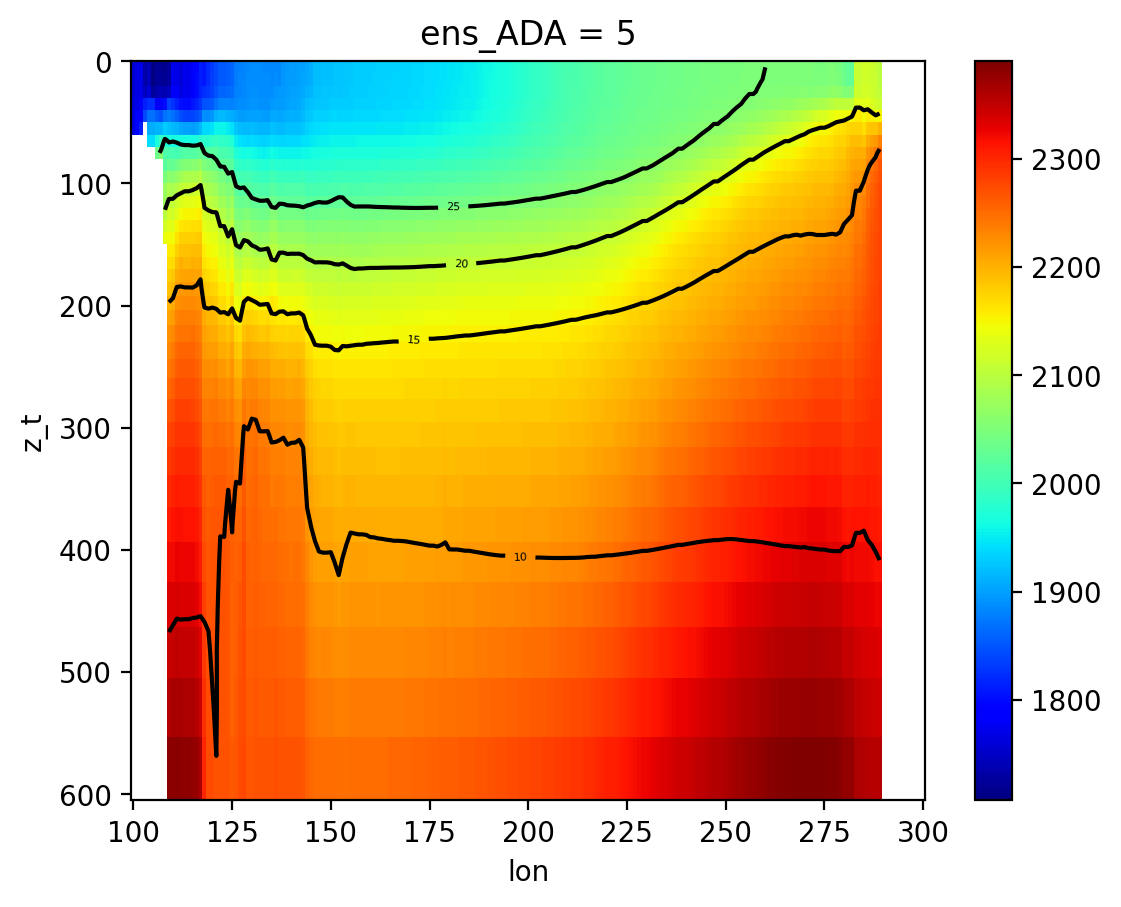

In [55]:
cmap='jet'

data_array=cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

fig, axes = plt.subplots(nrows=1, ncols=1, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=False)
contour_levels = [5, 10, 15, 20, 25]

# plt1=data_array.plot.pcolormesh(x='lon', y='z_t', ax=axes, cmap= cmap, add_colorbar=True)
plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes, cmap= cmap, add_colorbar=True)

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes, colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes.clabel(cs, inline=True, inline_spacing=8, fontsize=4)

axes.invert_yaxis()

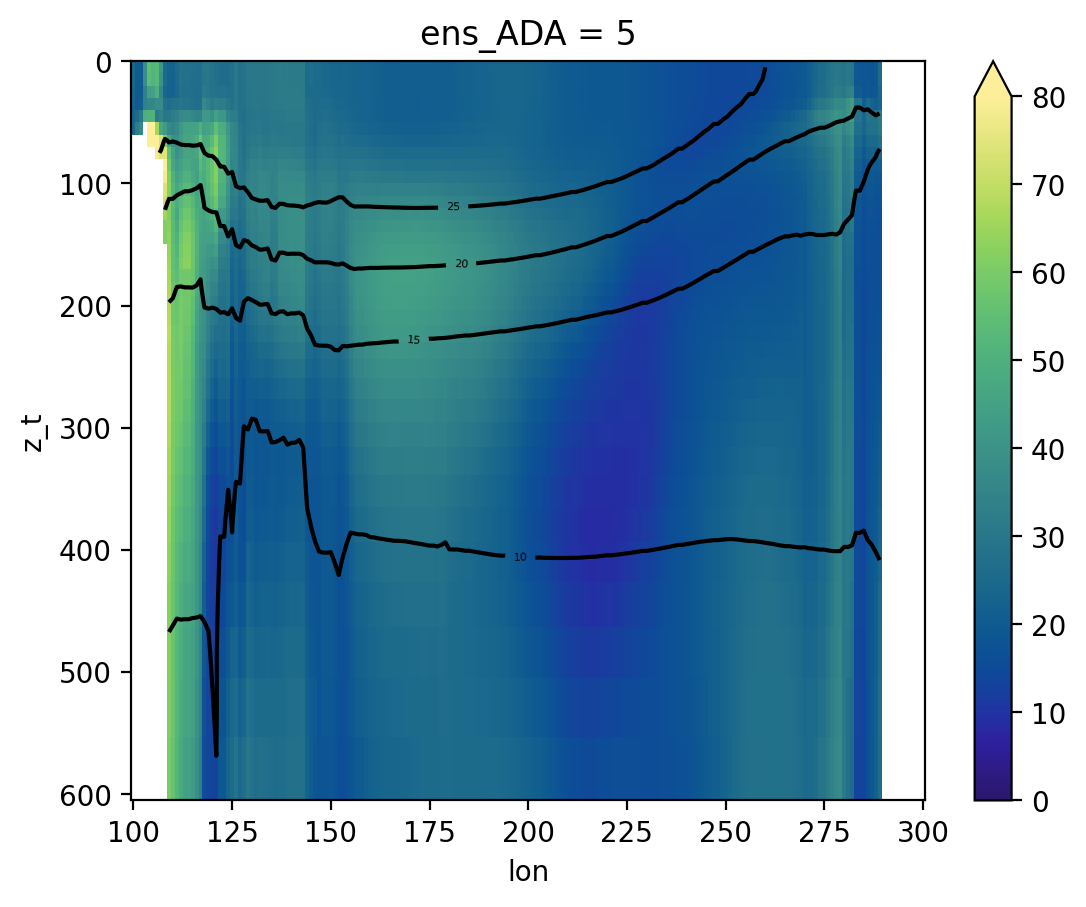

In [64]:
cmap=cmocean.cm.haline

data_array=cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

fig, axes = plt.subplots(nrows=1, ncols=1, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=False)
contour_levels = [5, 10, 15, 20, 25]

# plt1=data_array.plot.pcolormesh(x='lon', y='z_t', ax=axes, cmap= cmap, add_colorbar=True)
plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes, cmap= cmap, add_colorbar=True, 
                                  vmin=0, vmax=80, extend='max')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes, colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes.clabel(cs, inline=True, inline_spacing=8, fontsize=4)

axes.invert_yaxis()

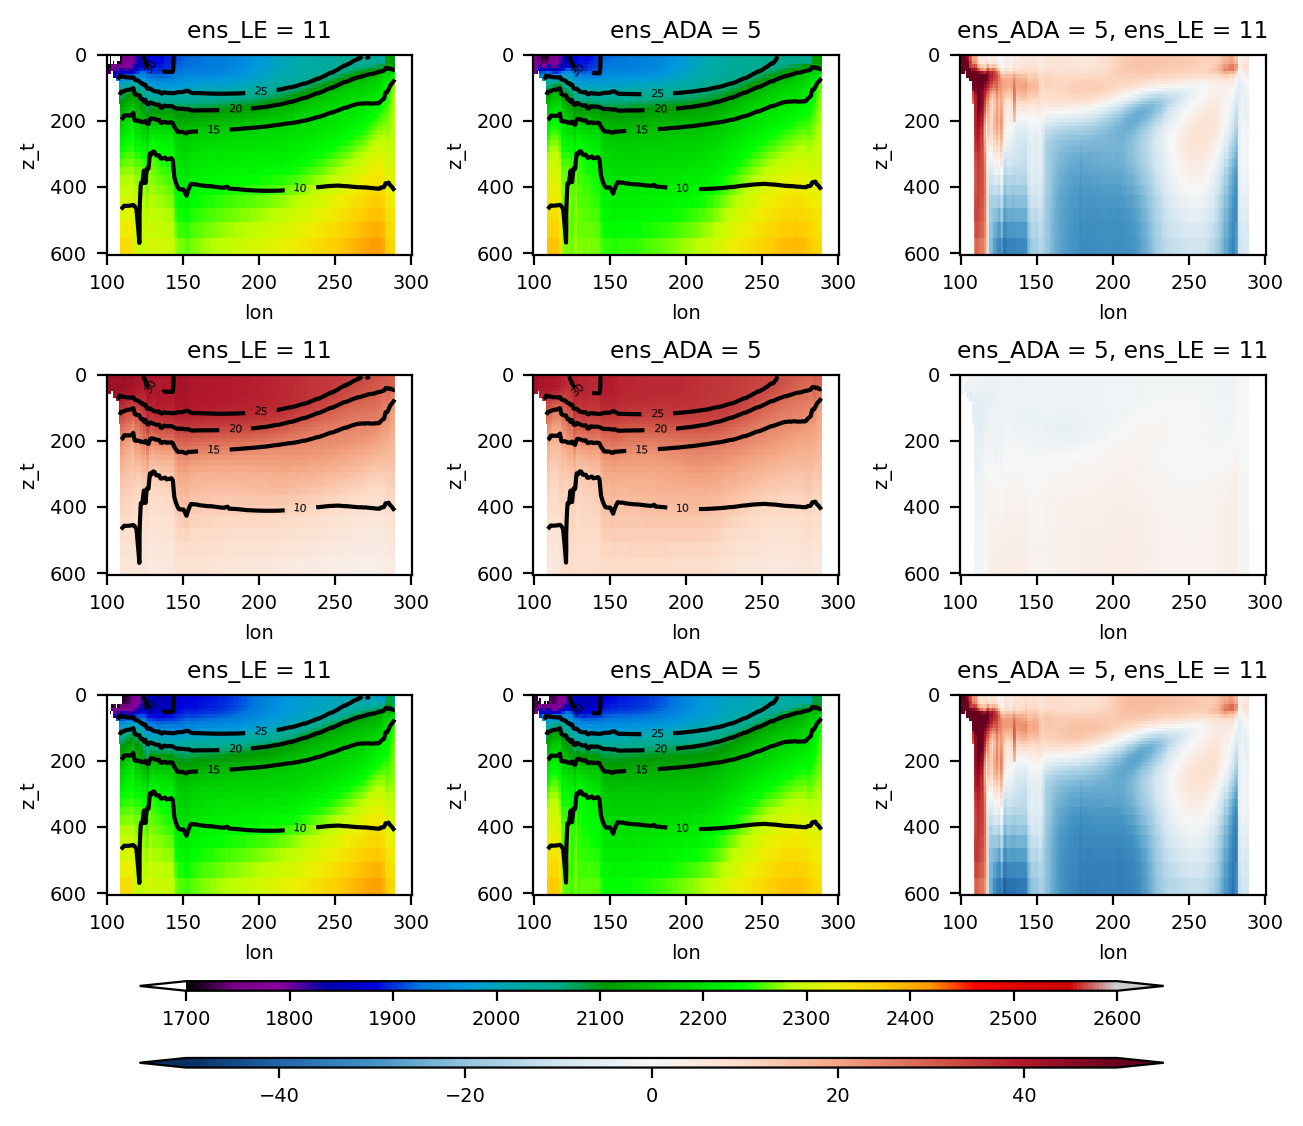

In [100]:
# 4*3 vertical section map (100 ~ 300E, -10 ~ 20N averaged)
# carbon storage changes (1994 - 1850(LE))

cmap = plt.get_cmap('nipy_spectral')
cmap.set_under("white")
cmap2 = plt.get_cmap('RdBu_r')
cmap3 =cmocean.cm.haline
fig, axes = plt.subplots(nrows=3, ncols=3, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)
contour_levels = [5, 10, 15, 20, 25, 30]

####################### DIC [0,0]   #######################
data_array=cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[0,0], cmap= cmap, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[0,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,0].invert_yaxis()


####################### DIC [0,1]   #######################
data_array=cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[0,1], cmap= cmap, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[0,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,1].invert_yaxis()

####################### DIC [0,2]   #######################
data_array= cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[0,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[0,2].invert_yaxis()


####################### DIC [1,0]   #######################
data_array=cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).mean(dim='time') - cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[1,0], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[1,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,0].invert_yaxis()


####################### DIC [1,1]   #######################
data_array=cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[1,1], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[1,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,1].invert_yaxis()



####################### DIC [1,2]   #######################
data_array= ( cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time')
             - (cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).mean(dim='time') - cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).mean(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[1,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[1,2].invert_yaxis()


####################### DIC [2,0]   #######################
data_array=cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[2,0], cmap= cmap, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[2,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,0].invert_yaxis()


####################### DIC [2,1]   #######################
data_array=cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[2,1], cmap= cmap, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[2,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,1].invert_yaxis()



####################### DIC [2,2]   #######################
data_array= cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[2,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[2,2].invert_yaxis()


cbar_a_c = fig.add_axes([0.1, -0.02, 0.8, 0.01])  # [left, bottom, width, height]
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='horizontal', extend='both')
# cbar1.set_label('R')
cbar1.ax.tick_params(labelsize=7)
plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

cbar_a_c2 = fig.add_axes([0.1, -0.1, 0.8, 0.01])  # [left, bottom, width, height]
cbar2 = fig.colorbar(plt2, cax=cbar_a_c2, orientation='horizontal', extend='both')
cbar2.ax.tick_params(labelsize=7)


plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격
plt.rcParams.update({'font.size': 7})
plt.show()

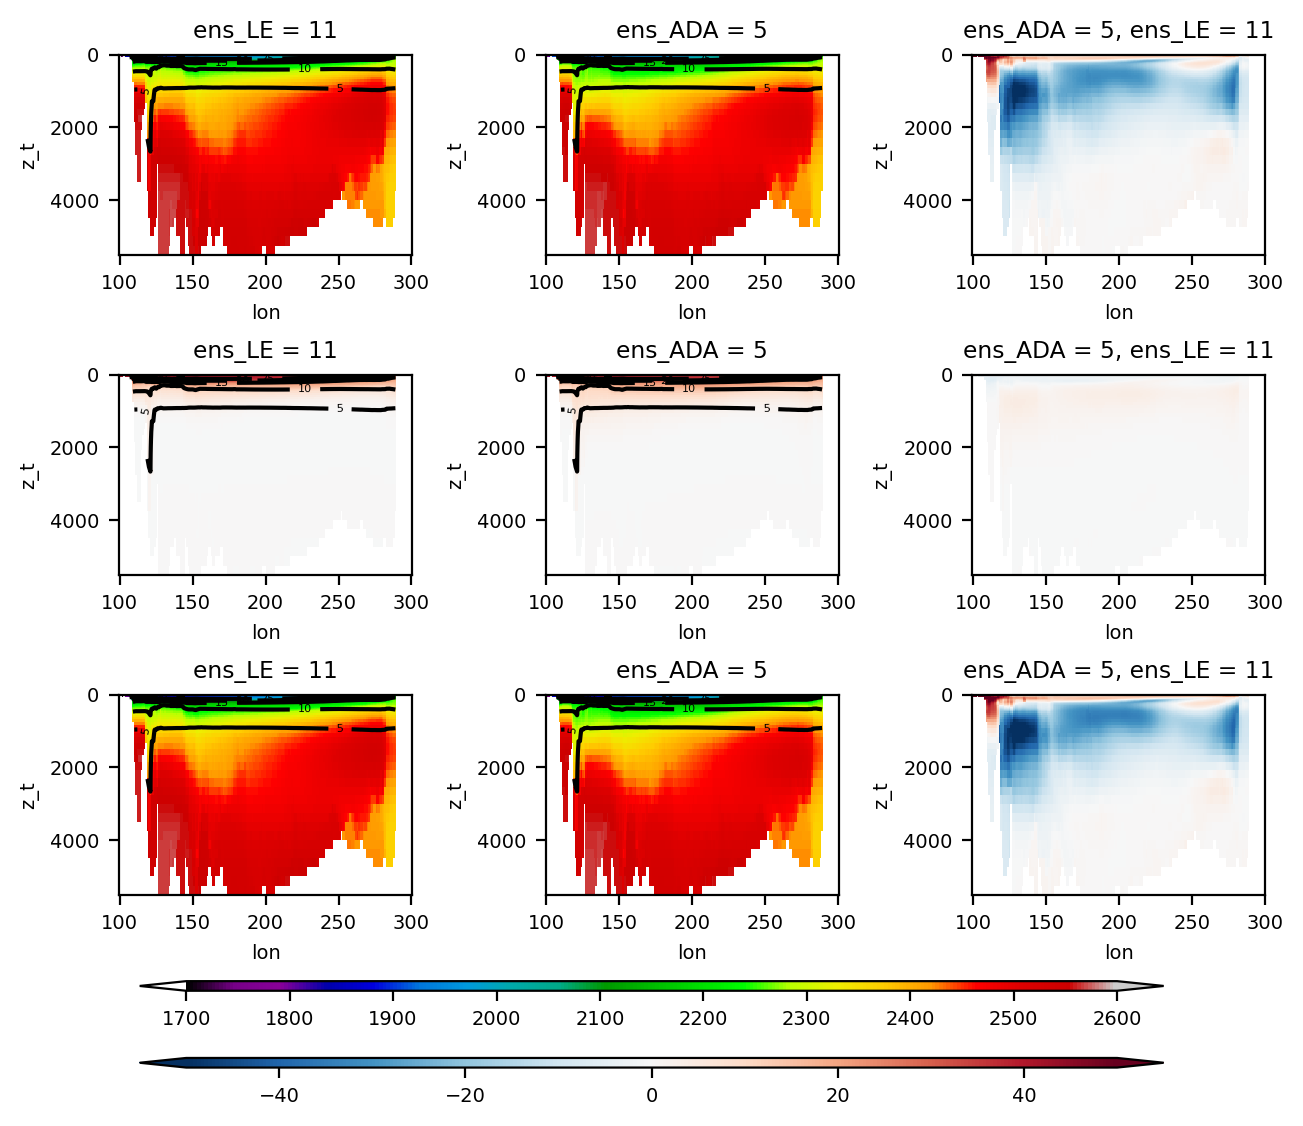

In [99]:
# 4*3 vertical section map (100 ~ 300E, -10 ~ 20N averaged)
# carbon storage changes (1994 - 1850(LE))

cmap = plt.get_cmap('nipy_spectral')
cmap.set_under("white")
cmap2 = plt.get_cmap('RdBu_r')
cmap3 =cmocean.cm.haline
fig, axes = plt.subplots(nrows=3, ncols=3, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)
contour_levels = [5, 10, 15, 20, 25, 30]

####################### DIC [0,0]   #######################
data_array=cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,60))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[0,0], cmap= cmap, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[0,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,0].invert_yaxis()


####################### DIC [0,1]   #######################
data_array=cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,60))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[0,1], cmap= cmap, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[0,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,1].invert_yaxis()

####################### DIC [0,2]   #######################
data_array= cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[0,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[0,2].invert_yaxis()


####################### DIC [1,0]   #######################
data_array=cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).mean(dim='time') - cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,60))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[1,0], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[1,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,0].invert_yaxis()


####################### DIC [1,1]   #######################
data_array=cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,60))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[1,1], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[1,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,1].invert_yaxis()



####################### DIC [1,2]   #######################
data_array= ( cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time')
             - (cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).mean(dim='time') - cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).mean(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[1,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[1,2].invert_yaxis()


####################### DIC [2,0]   #######################
data_array=cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,60))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[2,0], cmap= cmap, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[2,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,0].invert_yaxis()


####################### DIC [2,1]   #######################
data_array=cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,60))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[2,1], cmap= cmap, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[2,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,1].invert_yaxis()



####################### DIC [2,2]   #######################
data_array= cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[2,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[2,2].invert_yaxis()


cbar_a_c = fig.add_axes([0.1, -0.02, 0.8, 0.01])  # [left, bottom, width, height]
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='horizontal', extend='both')
# cbar1.set_label('R')
cbar1.ax.tick_params(labelsize=7)
plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

cbar_a_c2 = fig.add_axes([0.1, -0.1, 0.8, 0.01])  # [left, bottom, width, height]
cbar2 = fig.colorbar(plt2, cax=cbar_a_c2, orientation='horizontal', extend='both')
cbar2.ax.tick_params(labelsize=7)


plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격
plt.rcParams.update({'font.size': 7})
plt.show()

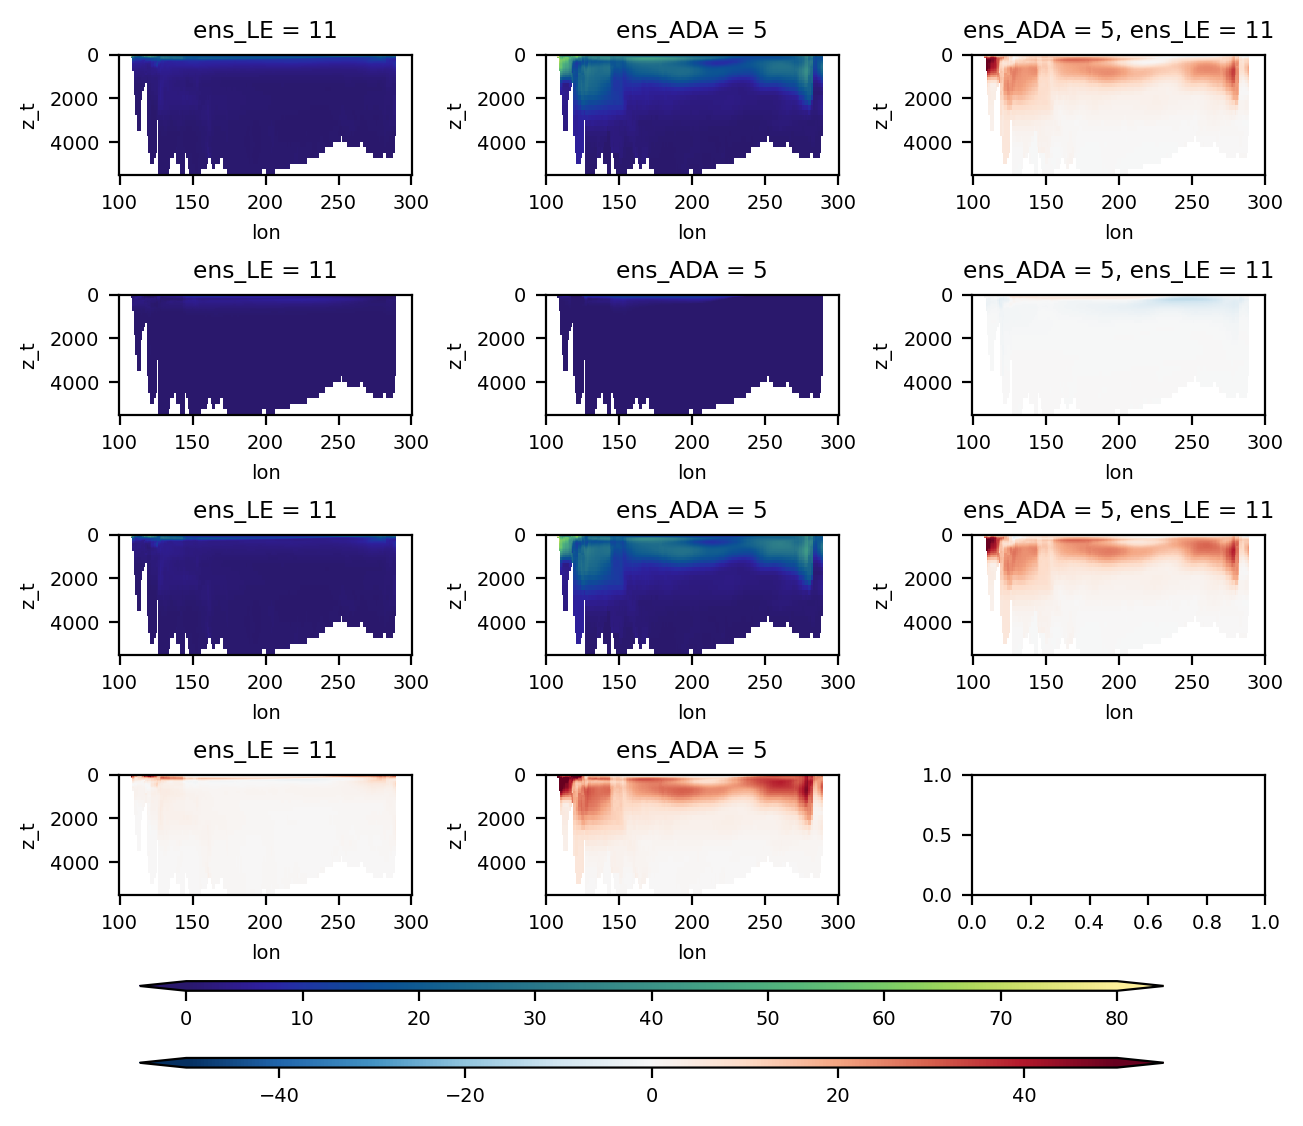

In [107]:
# 4*3 vertical section map (100 ~ 300E, -10 ~ 20N averaged)
# carbon storage changes (1994 - 1850(LE))

cmap = plt.get_cmap('nipy_spectral')
cmap.set_under("white")
cmap2 = plt.get_cmap('RdBu_r')
cmap3 =cmocean.cm.haline
fig, axes = plt.subplots(nrows=4, ncols=3, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)
contour_levels = [5, 10, 15, 20, 25, 30]

####################### DIC [0,0]   #######################
data_array=cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,60))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[0,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[0,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,0].invert_yaxis()


####################### DIC [0,1]   #######################
data_array=cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,60))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[0,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[0,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,1].invert_yaxis()

####################### DIC [0,2]   #######################
data_array= cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[0,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[0,2].invert_yaxis()


####################### DIC [1,0]   #######################
data_array=cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).std(dim='time') - cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,60))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[1,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[1,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,0].invert_yaxis()


####################### DIC [1,1]   #######################
data_array=cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,60))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[1,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[1,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,1].invert_yaxis()



####################### DIC [1,2]   #######################
data_array= ( cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).std(dim='time')
             - (cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).std(dim='time') - cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).std(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[1,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[1,2].invert_yaxis()


####################### DIC [2,0]   #######################
data_array=cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,60))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[2,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[2,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,0].invert_yaxis()


####################### DIC [2,1]   #######################
data_array=cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,60))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[2,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[2,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,1].invert_yaxis()



####################### DIC [2,2]   #######################
data_array= cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[2,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[2,2].invert_yaxis()


####################### DIC [3,0]   #######################
data_array= ( cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).std(dim='time') -
             (cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).std(dim='time') - cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).std(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,60))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[3,0], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[3,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,0].invert_yaxis()

####################### DIC [3,1]   #######################
data_array=( cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).std(dim='time') - 
            (cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).std(dim='time')))
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,60))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,60))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[3,1], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[3,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,1].invert_yaxis()



cbar_a_c = fig.add_axes([0.1, -0.02, 0.8, 0.01])  # [left, bottom, width, height]
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='horizontal', extend='both')
# cbar1.set_label('R')
cbar1.ax.tick_params(labelsize=7)
plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

cbar_a_c2 = fig.add_axes([0.1, -0.1, 0.8, 0.01])  # [left, bottom, width, height]
cbar2 = fig.colorbar(plt2, cax=cbar_a_c2, orientation='horizontal', extend='both')
cbar2.ax.tick_params(labelsize=7)


plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격
plt.rcParams.update({'font.size': 7})
plt.show()

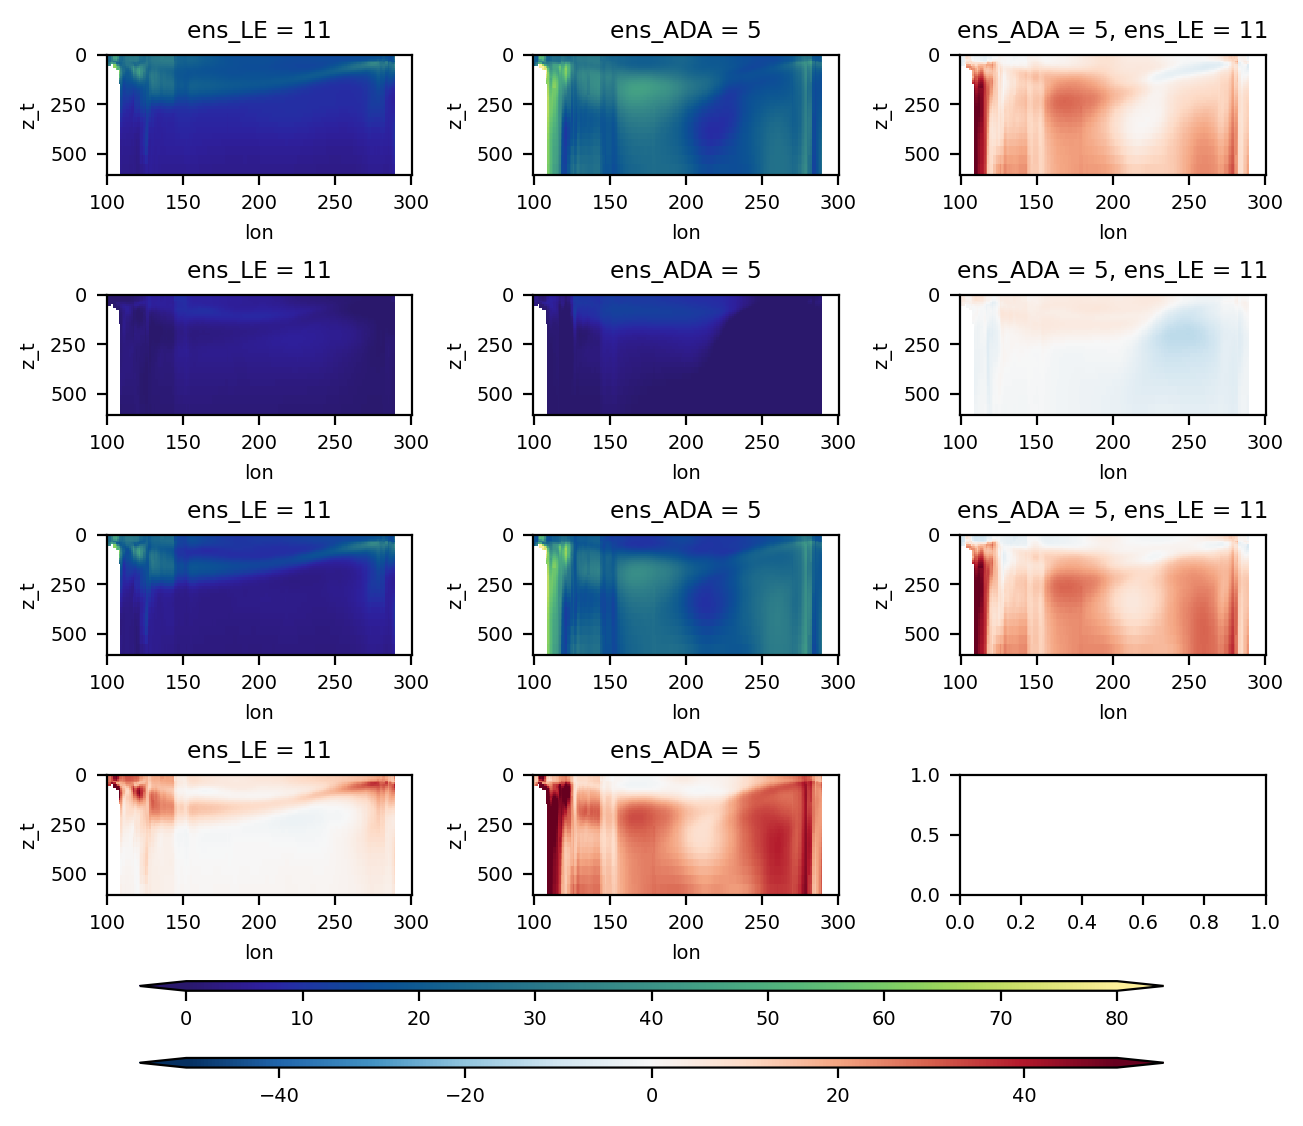

In [108]:
# 4*3 vertical section map (100 ~ 300E, -10 ~ 20N averaged)
# carbon storage changes (1994 - 1850(LE))

cmap = plt.get_cmap('nipy_spectral')
cmap.set_under("white")
cmap2 = plt.get_cmap('RdBu_r')
cmap3 =cmocean.cm.haline
fig, axes = plt.subplots(nrows=4, ncols=3, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)
contour_levels = [5, 10, 15, 20, 25, 30]

####################### DIC [0,0]   #######################
data_array=cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[0,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[0,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,0].invert_yaxis()


####################### DIC [0,1]   #######################
data_array=cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[0,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[0,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,1].invert_yaxis()

####################### DIC [0,2]   #######################
data_array= cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[0,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[0,2].invert_yaxis()


####################### DIC [1,0]   #######################
data_array=cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).std(dim='time') - cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[1,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[1,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,0].invert_yaxis()


####################### DIC [1,1]   #######################
data_array=cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[1,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[1,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,1].invert_yaxis()



####################### DIC [1,2]   #######################
data_array= ( cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).std(dim='time')
             - (cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).std(dim='time') - cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).std(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[1,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[1,2].invert_yaxis()


####################### DIC [2,0]   #######################
data_array=cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[2,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[2,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,0].invert_yaxis()


####################### DIC [2,1]   #######################
data_array=cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt1=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[2,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[2,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,1].invert_yaxis()



####################### DIC [2,2]   #######################
data_array= cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[2,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[2,2].invert_yaxis()


####################### DIC [3,0]   #######################
data_array= ( cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).std(dim='time') -
             (cfg_var_DIC_trop.LE_ds.sel(ens_LE=11).std(dim='time') - cfg_var_DIC_ALT_trop.LE_ds.sel(ens_LE=11).std(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.LE_ds.sel(ens_LE=11).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[3,0], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[3,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,0].invert_yaxis()

####################### DIC [3,1]   #######################
data_array=( cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).std(dim='time') - 
            (cfg_var_DIC_trop.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop.ADA_ds.sel(ens_ADA=5).std(dim='time')))
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))
lon_vals = data_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = data_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
data_for_plot = rolled.assign_coords(lon=lon_shifted)

temp_array=cfg_var_TEMP.ADA_ds.sel(ens_ADA=5).std(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))
lon_vals = temp_array.lon.values
idx_100 = np.argmin(np.abs(lon_vals - 100))
rolled = temp_array.roll(lon=-(idx_100), roll_coords=True)
lon_shifted = np.where(rolled.lon < 0, rolled.lon + 360, rolled.lon)
temp_for_plot = rolled.assign_coords(lon=lon_shifted)

plt2=data_for_plot.plot.pcolormesh(x='lon', y='z_t', ax=axes[3,1], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_for_plot.plot.contour(
    x='lon', y='z_t', ax=axes[3,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,1].invert_yaxis()



cbar_a_c = fig.add_axes([0.1, -0.02, 0.8, 0.01])  # [left, bottom, width, height]
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='horizontal', extend='both')
# cbar1.set_label('R')
cbar1.ax.tick_params(labelsize=7)
plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

cbar_a_c2 = fig.add_axes([0.1, -0.1, 0.8, 0.01])  # [left, bottom, width, height]
cbar2 = fig.colorbar(plt2, cax=cbar_a_c2, orientation='horizontal', extend='both')
cbar2.ax.tick_params(labelsize=7)


plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격
plt.rcParams.update({'font.size': 7})
plt.show()

In [112]:
# plot function (pop_add_cyclic) for raw data

def pop_add_cyclic(da):
        #copied from Mattew Longs github (https://gist.github.com/matt-long/50433da346da8ac17cde926eec90a87c) and modified for DA
        #This doesn't work with Dask (DA should be loaded)
        #Input DA must have the name and coords (TLONG and TLAT), and don't have other dims (time etc.)
        #Output is DA
        nj = da.TLAT.shape[0]
        ni = da.TLONG.shape[1]
        xL = int(ni/2 - 1)
        xR = int(xL + ni)
        tlon = da.TLONG.data
        tlat = da.TLAT.data
        tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)
        lon  = np.concatenate((tlon, tlon + 360.), 1)
        lon = lon[:, xL:xR]
        if ni == 320:
            lon[367:-3, 0] = lon[367:-3, 0] + 360.
        lon = lon - 360.
        lon = np.hstack((lon, lon[:, 0:1] + 360.))
        if ni == 320:
            lon[367:, -1] = lon[367:, -1] - 360.
        #-- trick cartopy into doing the right thing:
        #   it gets confused when the cyclic coords are identical
        lon[:, 0] = lon[:, 0] - 1e-8
        #-- periodicity
        lat = np.concatenate((tlat, tlat), 1)
        lat = lat[:, xL:xR]
        lat = np.hstack((lat, lat[:,0:1]))
        TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
        TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
        # copy vars
        v = da.name
        v_dims = da.dims
        # determine and sort other dimensions
        other_dims = set(v_dims) - {'nlat', 'nlon'}
        other_dims = tuple([d for d in v_dims if d in other_dims])
        lon_dim = da.dims.index('nlon')
        field = da.data
        field = np.concatenate((field, field), lon_dim)
        field = field[:, xL:xR]
        field = np.concatenate((field, field[:, 0:1]), lon_dim)
        dao = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), attrs=da.attrs)
        dao = dao.assign_coords(TLONG=TLONG)
        dao = dao.assign_coords(TLAT=TLAT)
        return dao

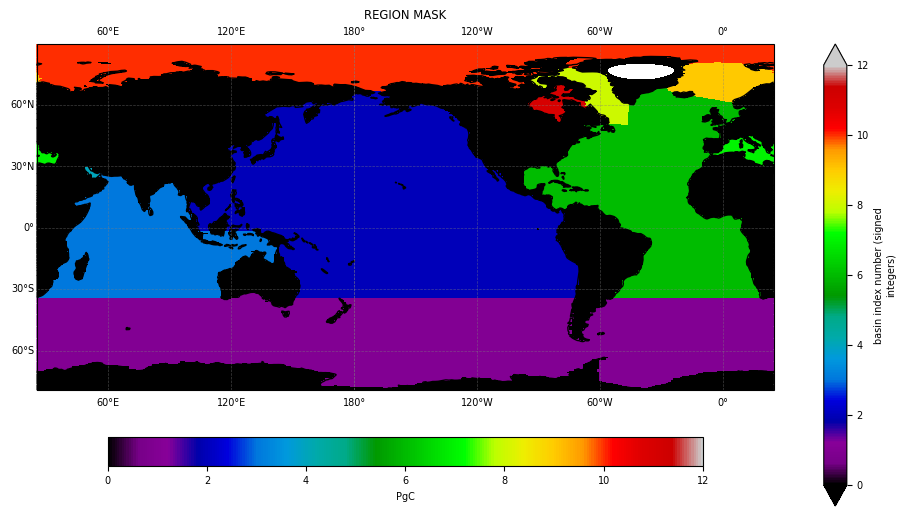

In [127]:
ds_grid.REGION_MASK
# southern ocean mask = (ds_grid['REGION_MASK'] == 1).astype(int)
# Atlantic mask = ((ds_grid['REGION_MASK'] >= 6) & (ds_grid['REGION_MASK'] <= 7)).astype(int)
# Indian mask = ((ds_grid['REGION_MASK'] >= 3) & (ds_grid['REGION_MASK'] <= 4)).astype(int)
# Pacific mask = (ds_grid['REGION_MASK'] == 2).astype(int)
# Arctic mask = ((ds_grid['REGION_MASK'] >= 8) & (ds_grid['REGION_MASK'] <= 11)).astype(int)


mask_pacific = ds_grid.REGION_MASK.where(ds_grid.REGION_MASK == 2)
mask_pacific=mask_pacific/mask_pacific
mask_atlantic = ((ds_grid['REGION_MASK'] >= 6) & (ds_grid['REGION_MASK'] <= 7)).astype(int)
mask_atlantic=mask_atlantic/mask_atlantic
mask_indian = ((ds_grid['REGION_MASK'] >= 3) & (ds_grid['REGION_MASK'] <= 4)).astype(int)
mask_indian = mask_indian/mask_indian



data_array = ds_grid.REGION_MASK
data_array['TLONG']=ds_grid.TLONG
data_array['TLAT']=ds_grid.TLAT
# data=data_array.utils.regrid()

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=205))  # PlateCarree 투영법

# cmap = plt.get_cmap('hot_r')
# cmap = plt.get_cmap('RdBu_r')  # 컬러맵 (빨간색-파란색 반전)
# cmap = plt.get_cmap('jet')  
cmap = plt.get_cmap('nipy_spectral')

# img = ax.pcolormesh(data['lon'], data['lat'], data, cmap=cmap, transform=ccrs.PlateCarree(), vmin=-dmax, vmax=dmax)
img=pop_add_cyclic(data_array).plot.pcolormesh(x='TLONG', y='TLAT', ax=ax, 
                        transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=True, vmin=0, vmax=12, extend='both')

cbar = plt.colorbar(img, orientation='horizontal', pad=0.1, shrink=0.8)
cbar.set_label('PgC')

ax.coastlines()  # 해안선 추가
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
plt.title('REGION MASK')

plt.show()




In [128]:
exceptcv2=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_DIC_trop.var, cfg_var_DIC_trop_ALT.var]

def process_coords_DIC_trop_Pacific(ds, sd, ed, mask_pacific, drop=True, except_coord_vars=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_DIC_trop.var]):
    import xcesm 
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        ds = ds* mask_pacific
        ds_rgd=ds.DIC.utils.regrid()
        # ds_rgd = ds_rgd.sel(lat=slice(-20,11))
        # ds_rgd = ds_rgd.where((ds_rgd.lon >= 100) | (ds_rgd.lon <= -60), drop=True)
        ds_rgd = ds_rgd.sel(lat=slice(-40,70))
        ds_rgd = ds_rgd.where((ds_rgd.lon >= 100) | (ds_rgd.lon <= -60), drop=True)

        R = 6371e3  # Earth radius (m)
        deg2rad = np.pi / 180
        lat_radians = ds_rgd.lat * deg2rad
        cell_area_1d = R**2 * deg2rad * deg2rad * np.cos(lat_radians)
        cell_area_2d = cell_area_1d.broadcast_like(ds_rgd)
        mask_area=ds_rgd / ds_rgd
        cell_area_2d=cell_area_2d*mask_area
        ds_rgd = ds_rgd * cell_area_2d
        ds_rgd =ds_rgd .sum(dim='lon')/cell_area_2d.sum(dim='lon')
       
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)

def process_coords_DIC_ALT_trop_Pacific(ds, sd, ed, mask_pacific, drop=True, except_coord_vars=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_DIC_trop_ALT.var]):
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        ds = ds* mask_pacific
        ds_rgd=ds.DIC_ALT_CO2.utils.regrid()
        # ds_rgd = ds_rgd.sel(lat=slice(-20,11))
        # ds_rgd = ds_rgd.where((ds_rgd.lon >= 100) | (ds_rgd.lon <= -60), drop=True)
        ds_rgd = ds_rgd.sel(lat=slice(-40,70))
        ds_rgd = ds_rgd.where((ds_rgd.lon >= 100) | (ds_rgd.lon <= -60), drop=True)

        R = 6371e3  # Earth radius (m)
        deg2rad = np.pi / 180
        lat_radians = ds_rgd.lat * deg2rad
        cell_area_1d = R**2 * deg2rad * deg2rad * np.cos(lat_radians)
        cell_area_2d = cell_area_1d.broadcast_like(ds_rgd)
        mask_area=ds_rgd / ds_rgd
        cell_area_2d=cell_area_2d*mask_area
        ds_rgd = ds_rgd * cell_area_2d
        ds_rgd =ds_rgd .sum(dim='lon')/cell_area_2d.sum(dim='lon')
       
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)


def process_coords_TEMP_Pacific(ds, sd, ed, mask_pacific, drop=True, except_coord_vars=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', 'TEMP']):
    import xcesm 
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        ds = ds* mask_pacific
        ds_rgd=ds.TEMP.utils.regrid()
        # ds_rgd = ds_rgd.sel(lat=slice(-20,11))
        # ds_rgd = ds_rgd.where((ds_rgd.lon >= 100) | (ds_rgd.lon <= -60), drop=True)
        ds_rgd = ds_rgd.sel(lat=slice(-40,70))
        ds_rgd = ds_rgd.where((ds_rgd.lon >= 100) | (ds_rgd.lon <= -60), drop=True)

        R = 6371e3  # Earth radius (m)
        deg2rad = np.pi / 180
        lat_radians = ds_rgd.lat * deg2rad
        cell_area_1d = R**2 * deg2rad * deg2rad * np.cos(lat_radians)
        cell_area_2d = cell_area_1d.broadcast_like(ds_rgd)
        mask_area=ds_rgd / ds_rgd
        cell_area_2d=cell_area_2d*mask_area
        ds_rgd = ds_rgd * cell_area_2d
        ds_rgd =ds_rgd .sum(dim='lon')/cell_area_2d.sum(dim='lon')
       
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)

In [129]:
# DIC_trop - Pacific

cfg_var_DIC_trop_pacific=CESM2_config()
cfg_var_DIC_trop_pacific.year_s=1955
cfg_var_DIC_trop_pacific.year_e=2020
cfg_var_DIC_trop_pacific.setvar('DIC')

cfg_var_TEMP_pacific=CESM2_config()
cfg_var_TEMP_pacific.year_s=1955
cfg_var_TEMP_pacific.year_e=2020
cfg_var_TEMP_pacific.setvar('TEMP')

cfg_var_DIC_ALT_trop_pacific=CESM2_config()
cfg_var_DIC_ALT_trop_pacific.year_s=1955
cfg_var_DIC_ALT_trop_pacific.year_e=2020
cfg_var_DIC_ALT_trop_pacific.setvar('DIC_ALT_CO2')

start_time = time.time()

cfg_var_DIC_trop_pacific.LE_path_load(cfg_var_DIC_trop_pacific.var)
cfg_var_DIC_trop_pacific.LE_ds = xr.open_mfdataset(cfg_var_DIC_trop_pacific.LE_file_list[0][11:13], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC_trop_pacific.LE_ensembles[11:13]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_trop_Pacific(ds, start_date, end_date, mask_pacific),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_trop_pacific.LE_ds = cfg_var_DIC_trop_pacific.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_DIC_trop_pacific.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_trop_pacific.LE_ds.time))
cfg_var_DIC_trop_pacific.LE_ds = cfg_var_DIC_trop_pacific.LE_ds.assign_coords(time=new_time)


cfg_var_DIC_trop_pacific.ADA_path_load(cfg_var_DIC_trop_pacific.var)
cfg_var_DIC_trop_pacific.ADA_ds = xr.open_mfdataset(cfg_var_DIC_trop_pacific.ADA_file_list[0][4:6], 
                       chunks={'time': 2}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_DIC_trop_pacific.ADA_ensembles[4:6]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_trop_Pacific(ds, start_date, end_date, mask_pacific),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_trop_pacific.ADA_ds = cfg_var_DIC_trop_pacific.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_DIC_trop_pacific.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_trop_pacific.ADA_ds.time))
cfg_var_DIC_trop_pacific.ADA_ds = cfg_var_DIC_trop_pacific.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading DIC_trop: ' + str(elapsed_time))


# DIC_ALT_trop

start_time = time.time()

cfg_var_DIC_ALT_trop_pacific=CESM2_config()
cfg_var_DIC_ALT_trop_pacific.year_s=1955
cfg_var_DIC_ALT_trop_pacific.year_e=2020
cfg_var_DIC_ALT_trop_pacific.setvar('DIC_ALT_CO2')

cfg_var_DIC_ALT_trop_pacific.LE_path_load(cfg_var_DIC_ALT_trop_pacific.var)
cfg_var_DIC_ALT_trop_pacific.LE_ds = xr.open_mfdataset(cfg_var_DIC_ALT_trop_pacific.LE_file_list[0][11:13], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC_ALT_trop_pacific.LE_ensembles[11:13]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_ALT_trop_Pacific(ds, start_date, end_date, mask_pacific),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_ALT_trop_pacific.LE_ds = cfg_var_DIC_ALT_trop_pacific.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_DIC_ALT_trop_pacific.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_ALT_trop_pacific.LE_ds.time))
cfg_var_DIC_ALT_trop_pacific.LE_ds = cfg_var_DIC_ALT_trop_pacific.LE_ds.assign_coords(time=new_time)


cfg_var_DIC_ALT_trop_pacific.ADA_path_load(cfg_var_DIC_ALT_trop_pacific.var)
cfg_var_DIC_ALT_trop_pacific.ADA_ds = xr.open_mfdataset(cfg_var_DIC_ALT_trop_pacific.ADA_file_list[0][4:6], 
                       chunks={'time': 2}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_DIC_ALT_trop_pacific.ADA_ensembles[4:6]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_ALT_trop_Pacific(ds, start_date, end_date, mask_pacific),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_ALT_trop_pacific.ADA_ds = cfg_var_DIC_ALT_trop_pacific.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_DIC_ALT_trop_pacific.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_ALT_trop_pacific.ADA_ds.time))
cfg_var_DIC_ALT_trop_pacific.ADA_ds = cfg_var_DIC_ALT_trop_pacific.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading DIC_ALT_trop: ' + str(elapsed_time))

# TEMP

start_time = time.time()

cfg_var_TEMP_pacific.LE_path_load(cfg_var_TEMP_pacific.var)
cfg_var_TEMP_pacific.LE_ds = xr.open_mfdataset(cfg_var_TEMP_pacific.LE_file_list[0][11:13], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP_pacific.LE_ensembles[11:13]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_TEMP_Pacific(ds, start_date, end_date, mask_pacific),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TEMP_pacific.LE_ds = cfg_var_TEMP_pacific.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_TEMP_pacific.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP_pacific.LE_ds.time))
cfg_var_TEMP_pacific.LE_ds = cfg_var_TEMP_pacific.LE_ds.assign_coords(time=new_time)


cfg_var_TEMP_pacific.ADA_path_load(cfg_var_TEMP_pacific.var)
cfg_var_TEMP_pacific.ADA_ds = xr.open_mfdataset(cfg_var_TEMP_pacific.ADA_file_list[0][4:6], 
                       chunks={'time': 2}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_TEMP_pacific.ADA_ensembles[4:6]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_TEMP_Pacific(ds, start_date, end_date, mask_pacific),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TEMP_pacific.ADA_ds = cfg_var_TEMP_pacific.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_TEMP_pacific.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP_pacific.ADA_ds.time))
cfg_var_TEMP_pacific.ADA_ds = cfg_var_TEMP_pacific.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading TEMP: ' + str(elapsed_time))

elasped time for reading DIC_trop: 288.1359188556671
elasped time for reading DIC_ALT_trop: 344.5876352787018
elasped time for reading TEMP: 358.97063517570496


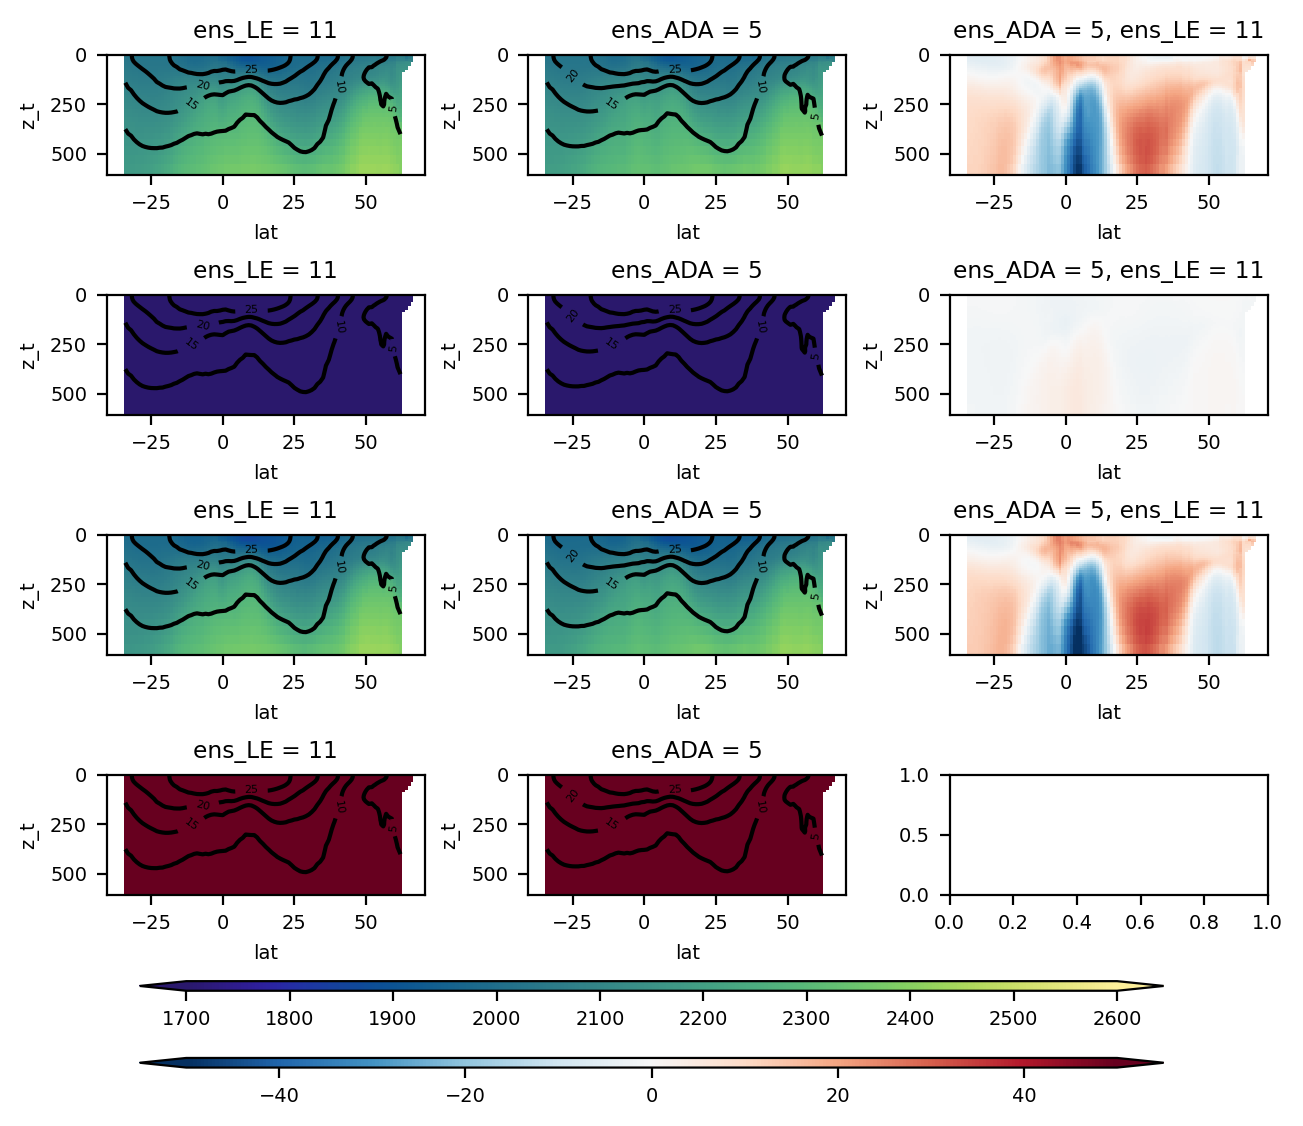

In [142]:
# 4*3 vertical section map (Pacific longitudinal averaged)
# carbon storage changes (1994 - 1850(LE))

cmap = plt.get_cmap('nipy_spectral')
cmap.set_under("white")
cmap2 = plt.get_cmap('RdBu_r')
cmap3 =cmocean.cm.haline
fig, axes = plt.subplots(nrows=4, ncols=3, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)
contour_levels = [5, 10, 15, 20, 25, 30]

####################### DIC [0,0]   #######################
data_array=cfg_var_DIC_trop_pacific.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_pacific.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[0,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,0].invert_yaxis()


####################### DIC [0,1]   #######################
data_array=cfg_var_DIC_trop_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))


temp_array=cfg_var_TEMP_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[0,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,1].invert_yaxis()

####################### DIC [0,2]   #######################
data_array= cfg_var_DIC_trop_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_trop_pacific.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[0,2].invert_yaxis()


####################### DIC [1,0]   #######################
data_array=cfg_var_DIC_trop_pacific.LE_ds.sel(ens_LE=11).mean(dim='time') - cfg_var_DIC_ALT_trop_pacific.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_pacific.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[1,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,0].invert_yaxis()


####################### DIC [1,1]   #######################
data_array=cfg_var_DIC_trop_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[1,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,1].invert_yaxis()



####################### DIC [1,2]   #######################
data_array= ( cfg_var_DIC_trop_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time')
             - (cfg_var_DIC_trop_pacific.LE_ds.sel(ens_LE=11).mean(dim='time') - cfg_var_DIC_ALT_trop_pacific.LE_ds.sel(ens_LE=11).mean(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[1,2].invert_yaxis()


####################### DIC [2,0]   #######################
data_array=cfg_var_DIC_ALT_trop_pacific.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_pacific.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[2,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,0].invert_yaxis()


####################### DIC [2,1]   #######################
data_array=cfg_var_DIC_ALT_trop_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[2,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,1].invert_yaxis()



####################### DIC [2,2]   #######################
data_array= cfg_var_DIC_ALT_trop_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop_pacific.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[2,2].invert_yaxis()


####################### DIC [3,0]   #######################
data_array= ( cfg_var_DIC_ALT_trop_pacific.LE_ds.sel(ens_LE=11).mean(dim='time') -
             (cfg_var_DIC_trop_pacific.LE_ds.sel(ens_LE=11).mean(dim='time') - cfg_var_DIC_ALT_trop_pacific.LE_ds.sel(ens_LE=11).mean(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_pacific.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[3,0], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[3,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,0].invert_yaxis()

####################### DIC [3,1]   #######################
data_array=( cfg_var_DIC_ALT_trop_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time') - 
            (cfg_var_DIC_trop_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time')))
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[3,1], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[3,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,1].invert_yaxis()


cbar_a_c = fig.add_axes([0.1, -0.02, 0.8, 0.01])  # [left, bottom, width, height]
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='horizontal', extend='both')
# cbar1.set_label('R')
cbar1.ax.tick_params(labelsize=7)
plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

cbar_a_c2 = fig.add_axes([0.1, -0.1, 0.8, 0.01])  # [left, bottom, width, height]
cbar2 = fig.colorbar(plt2, cax=cbar_a_c2, orientation='horizontal', extend='both')
cbar2.ax.tick_params(labelsize=7)


plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격
plt.rcParams.update({'font.size': 7})
plt.show()

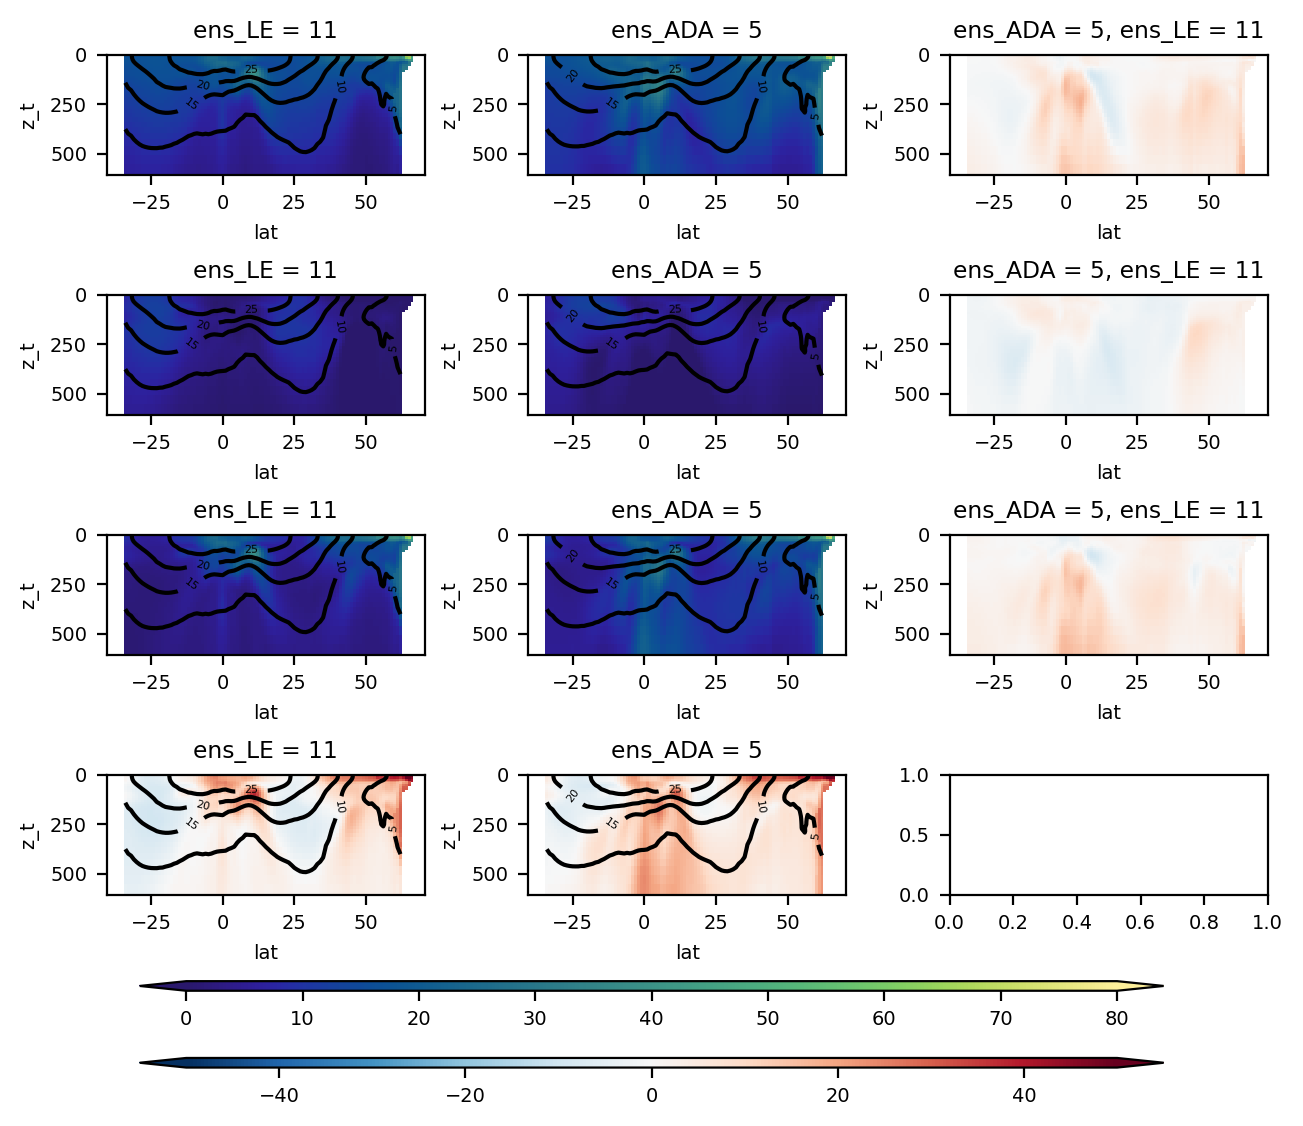

In [151]:
# 4*3 vertical section map (Pacific longitudinal std)
# carbon storage changes (1994 - 1850(LE))

cmap = plt.get_cmap('nipy_spectral')
cmap.set_under("white")
cmap2 = plt.get_cmap('RdBu_r')
cmap3 =cmocean.cm.haline
fig, axes = plt.subplots(nrows=4, ncols=3, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)
contour_levels = [5, 10, 15, 20, 25, 30]

####################### DIC [0,0]   #######################
data_array=cfg_var_DIC_trop_pacific.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_pacific.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[0,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,0].invert_yaxis()


####################### DIC [0,1]   #######################
data_array=cfg_var_DIC_trop_pacific.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))


temp_array=cfg_var_TEMP_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[0,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,1].invert_yaxis()

####################### DIC [0,2]   #######################
data_array= cfg_var_DIC_trop_pacific.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_trop_pacific.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[0,2].invert_yaxis()


####################### DIC [1,0]   #######################
data_array=cfg_var_DIC_trop_pacific.LE_ds.sel(ens_LE=11).std(dim='time') - cfg_var_DIC_ALT_trop_pacific.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_pacific.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[1,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,0].invert_yaxis()


####################### DIC [1,1]   #######################
data_array=cfg_var_DIC_trop_pacific.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop_pacific.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[1,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,1].invert_yaxis()



####################### DIC [1,2]   #######################
data_array= ( cfg_var_DIC_trop_pacific.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop_pacific.ADA_ds.sel(ens_ADA=5).std(dim='time')
             - (cfg_var_DIC_trop_pacific.LE_ds.sel(ens_LE=11).std(dim='time') - cfg_var_DIC_ALT_trop_pacific.LE_ds.sel(ens_LE=11).std(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[1,2].invert_yaxis()


####################### DIC [2,0]   #######################
data_array=cfg_var_DIC_ALT_trop_pacific.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_pacific.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[2,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,0].invert_yaxis()


####################### DIC [2,1]   #######################
data_array=cfg_var_DIC_ALT_trop_pacific.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[2,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,1].invert_yaxis()



####################### DIC [2,2]   #######################
data_array= cfg_var_DIC_ALT_trop_pacific.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop_pacific.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[2,2].invert_yaxis()


####################### DIC [3,0]   #######################
data_array= ( cfg_var_DIC_ALT_trop_pacific.LE_ds.sel(ens_LE=11).std(dim='time') -
             (cfg_var_DIC_trop_pacific.LE_ds.sel(ens_LE=11).std(dim='time') - cfg_var_DIC_ALT_trop_pacific.LE_ds.sel(ens_LE=11).std(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_pacific.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[3,0], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[3,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,0].invert_yaxis()

####################### DIC [3,1]   #######################
data_array=( cfg_var_DIC_ALT_trop_pacific.ADA_ds.sel(ens_ADA=5).std(dim='time') - 
            (cfg_var_DIC_trop_pacific.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop_pacific.ADA_ds.sel(ens_ADA=5).std(dim='time')))
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_pacific.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[3,1], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[3,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,1].invert_yaxis()


cbar_a_c = fig.add_axes([0.1, -0.02, 0.8, 0.01])  # [left, bottom, width, height]
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='horizontal', extend='both')
# cbar1.set_label('R')
cbar1.ax.tick_params(labelsize=7)
plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

cbar_a_c2 = fig.add_axes([0.1, -0.1, 0.8, 0.01])  # [left, bottom, width, height]
cbar2 = fig.colorbar(plt2, cax=cbar_a_c2, orientation='horizontal', extend='both')
cbar2.ax.tick_params(labelsize=7)


plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격
plt.rcParams.update({'font.size': 7})
plt.show()

In [145]:
exceptcv2=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_DIC_trop.var, cfg_var_DIC_trop_ALT.var]

def process_coords_DIC_trop_atlantic(ds, sd, ed, mask_Atlantic, drop=True, except_coord_vars=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_DIC_trop.var]):
    import xcesm 
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        ds = ds* mask_Atlantic
        ds_rgd=ds.DIC.utils.regrid()
        # ds_rgd = ds_rgd.sel(lat=slice(-20,11))
        # ds_rgd = ds_rgd.where((ds_rgd.lon >= -50) | (ds_rgd.lon <= -50), drop=True).sum(dim='lon')/cell_area_2d.sum(dim='lon')
        ds_rgd = ds_rgd.sel(lat=slice(-40,70))
        ds_rgd = ds_rgd.where((ds_rgd.lon >= -110) & (ds_rgd.lon <= 50), drop=True)

        R = 6371e3  # Earth radius (m)
        deg2rad = np.pi / 180
        lat_radians = ds_rgd.lat * deg2rad
        cell_area_1d = R**2 * deg2rad * deg2rad * np.cos(lat_radians)
        cell_area_2d = cell_area_1d.broadcast_like(ds_rgd)
        mask_area=ds_rgd / ds_rgd
        cell_area_2d=cell_area_2d*mask_area
        ds_rgd = ds_rgd * cell_area_2d
        ds_rgd =ds_rgd .sum(dim='lon')/cell_area_2d.sum(dim='lon')
       
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)

def process_coords_DIC_ALT_trop_atlantic(ds, sd, ed, mask_Atlantic, drop=True, except_coord_vars=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_DIC_trop_ALT.var]):
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        ds = ds* mask_Atlantic
        ds_rgd=ds.DIC_ALT_CO2.utils.regrid()
        # ds_rgd = ds_rgd.sel(lat=slice(-20,11))
        # ds_rgd = ds_rgd.where((ds_rgd.lon >= -50) | (ds_rgd.lon <= -50), drop=True).sum(dim='lon')/cell_area_2d.sum(dim='lon')
        ds_rgd = ds_rgd.sel(lat=slice(-40,70))
        ds_rgd = ds_rgd.where((ds_rgd.lon >= -110) & (ds_rgd.lon <= 50), drop=True)

        R = 6371e3  # Earth radius (m)
        deg2rad = np.pi / 180
        lat_radians = ds_rgd.lat * deg2rad
        cell_area_1d = R**2 * deg2rad * deg2rad * np.cos(lat_radians)
        cell_area_2d = cell_area_1d.broadcast_like(ds_rgd)
        mask_area=ds_rgd / ds_rgd
        cell_area_2d=cell_area_2d*mask_area
        ds_rgd = ds_rgd * cell_area_2d
        ds_rgd =ds_rgd .sum(dim='lon')/cell_area_2d.sum(dim='lon')
       
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)


def process_coords_TEMP_atlantic(ds, sd, ed, mask_Atlantic, drop=True, except_coord_vars=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', 'TEMP']):
    import xcesm 
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        ds = ds* mask_Atlantic
        ds_rgd=ds.TEMP.utils.regrid()
        # ds_rgd = ds_rgd.sel(lat=slice(-20,11))
        # ds_rgd = ds_rgd.where((ds_rgd.lon >= -50) | (ds_rgd.lon <= -50), drop=True).sum(dim='lon')/cell_area_2d.sum(dim='lon')
        ds_rgd = ds_rgd.sel(lat=slice(-40,70))
        ds_rgd = ds_rgd.where((ds_rgd.lon >= -110) & (ds_rgd.lon <= 50), drop=True)

        R = 6371e3  # Earth radius (m)
        deg2rad = np.pi / 180
        lat_radians = ds_rgd.lat * deg2rad
        cell_area_1d = R**2 * deg2rad * deg2rad * np.cos(lat_radians)
        cell_area_2d = cell_area_1d.broadcast_like(ds_rgd)
        mask_area=ds_rgd / ds_rgd
        cell_area_2d=cell_area_2d*mask_area
        ds_rgd = ds_rgd * cell_area_2d
        ds_rgd =ds_rgd .sum(dim='lon')/cell_area_2d.sum(dim='lon')
       
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)

In [146]:
# DIC_trop - Atlantic

cfg_var_DIC_trop_atlantic=CESM2_config()
cfg_var_DIC_trop_atlantic.year_s=1955
cfg_var_DIC_trop_atlantic.year_e=2020
cfg_var_DIC_trop_atlantic.setvar('DIC')

cfg_var_TEMP_atlantic=CESM2_config()
cfg_var_TEMP_atlantic.year_s=1955
cfg_var_TEMP_atlantic.year_e=2020
cfg_var_TEMP_atlantic.setvar('TEMP')

cfg_var_DIC_ALT_trop_atlantic=CESM2_config()
cfg_var_DIC_ALT_trop_atlantic.year_s=1955
cfg_var_DIC_ALT_trop_atlantic.year_e=2020
cfg_var_DIC_ALT_trop_atlantic.setvar('DIC_ALT_CO2')

start_time = time.time()

cfg_var_DIC_trop_atlantic.LE_path_load(cfg_var_DIC_trop_atlantic.var)
cfg_var_DIC_trop_atlantic.LE_ds = xr.open_mfdataset(cfg_var_DIC_trop_atlantic.LE_file_list[0][11:13], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC_trop_atlantic.LE_ensembles[11:13]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_trop_atlantic(ds, start_date, end_date, mask_atlantic),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_trop_atlantic.LE_ds = cfg_var_DIC_trop_atlantic.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_DIC_trop_atlantic.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_trop_atlantic.LE_ds.time))
cfg_var_DIC_trop_atlantic.LE_ds = cfg_var_DIC_trop_atlantic.LE_ds.assign_coords(time=new_time)


cfg_var_DIC_trop_atlantic.ADA_path_load(cfg_var_DIC_trop_atlantic.var)
cfg_var_DIC_trop_atlantic.ADA_ds = xr.open_mfdataset(cfg_var_DIC_trop_atlantic.ADA_file_list[0][4:6], 
                       chunks={'time': 2}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_DIC_trop_atlantic.ADA_ensembles[4:6]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_trop_atlantic(ds, start_date, end_date, mask_atlantic),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_trop_atlantic.ADA_ds = cfg_var_DIC_trop_atlantic.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_DIC_trop_atlantic.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_trop_atlantic.ADA_ds.time))
cfg_var_DIC_trop_atlantic.ADA_ds = cfg_var_DIC_trop_atlantic.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading DIC_trop: ' + str(elapsed_time))


# DIC_ALT_trop

start_time = time.time()

cfg_var_DIC_ALT_trop_atlantic=CESM2_config()
cfg_var_DIC_ALT_trop_atlantic.year_s=1955
cfg_var_DIC_ALT_trop_atlantic.year_e=2020
cfg_var_DIC_ALT_trop_atlantic.setvar('DIC_ALT_CO2')

cfg_var_DIC_ALT_trop_atlantic.LE_path_load(cfg_var_DIC_ALT_trop_atlantic.var)
cfg_var_DIC_ALT_trop_atlantic.LE_ds = xr.open_mfdataset(cfg_var_DIC_ALT_trop_atlantic.LE_file_list[0][11:13], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC_ALT_trop_atlantic.LE_ensembles[11:13]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_ALT_trop_atlantic(ds, start_date, end_date, mask_atlantic),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_ALT_trop_atlantic.LE_ds = cfg_var_DIC_ALT_trop_atlantic.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_DIC_ALT_trop_atlantic.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_ALT_trop_atlantic.LE_ds.time))
cfg_var_DIC_ALT_trop_atlantic.LE_ds = cfg_var_DIC_ALT_trop_atlantic.LE_ds.assign_coords(time=new_time)


cfg_var_DIC_ALT_trop_atlantic.ADA_path_load(cfg_var_DIC_ALT_trop_atlantic.var)
cfg_var_DIC_ALT_trop_atlantic.ADA_ds = xr.open_mfdataset(cfg_var_DIC_ALT_trop_atlantic.ADA_file_list[0][4:6], 
                       chunks={'time': 2}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_DIC_ALT_trop_atlantic.ADA_ensembles[4:6]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_ALT_trop_atlantic(ds, start_date, end_date, mask_atlantic),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_ALT_trop_atlantic.ADA_ds = cfg_var_DIC_ALT_trop_atlantic.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_DIC_ALT_trop_atlantic.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_ALT_trop_atlantic.ADA_ds.time))
cfg_var_DIC_ALT_trop_atlantic.ADA_ds = cfg_var_DIC_ALT_trop_atlantic.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading DIC_ALT_trop: ' + str(elapsed_time))

# TEMP

start_time = time.time()

cfg_var_TEMP_atlantic.LE_path_load(cfg_var_TEMP_atlantic.var)
cfg_var_TEMP_atlantic.LE_ds = xr.open_mfdataset(cfg_var_TEMP_atlantic.LE_file_list[0][11:13], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP_atlantic.LE_ensembles[11:13]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_TEMP_atlantic(ds, start_date, end_date, mask_atlantic),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TEMP_atlantic.LE_ds = cfg_var_TEMP_atlantic.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_TEMP_atlantic.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP_atlantic.LE_ds.time))
cfg_var_TEMP_atlantic.LE_ds = cfg_var_TEMP_atlantic.LE_ds.assign_coords(time=new_time)


cfg_var_TEMP_atlantic.ADA_path_load(cfg_var_TEMP_atlantic.var)
cfg_var_TEMP_atlantic.ADA_ds = xr.open_mfdataset(cfg_var_TEMP_atlantic.ADA_file_list[0][4:6], 
                       chunks={'time': 2}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_TEMP_atlantic.ADA_ensembles[4:6]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_TEMP_atlantic(ds, start_date, end_date, mask_atlantic),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TEMP_atlantic.ADA_ds = cfg_var_TEMP_atlantic.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_TEMP_atlantic.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP_atlantic.ADA_ds.time))
cfg_var_TEMP_atlantic.ADA_ds = cfg_var_TEMP_atlantic.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading TEMP: ' + str(elapsed_time))

elasped time for reading DIC_trop: 297.33265137672424
elasped time for reading DIC_ALT_trop: 356.35698437690735
elasped time for reading TEMP: 330.37651777267456


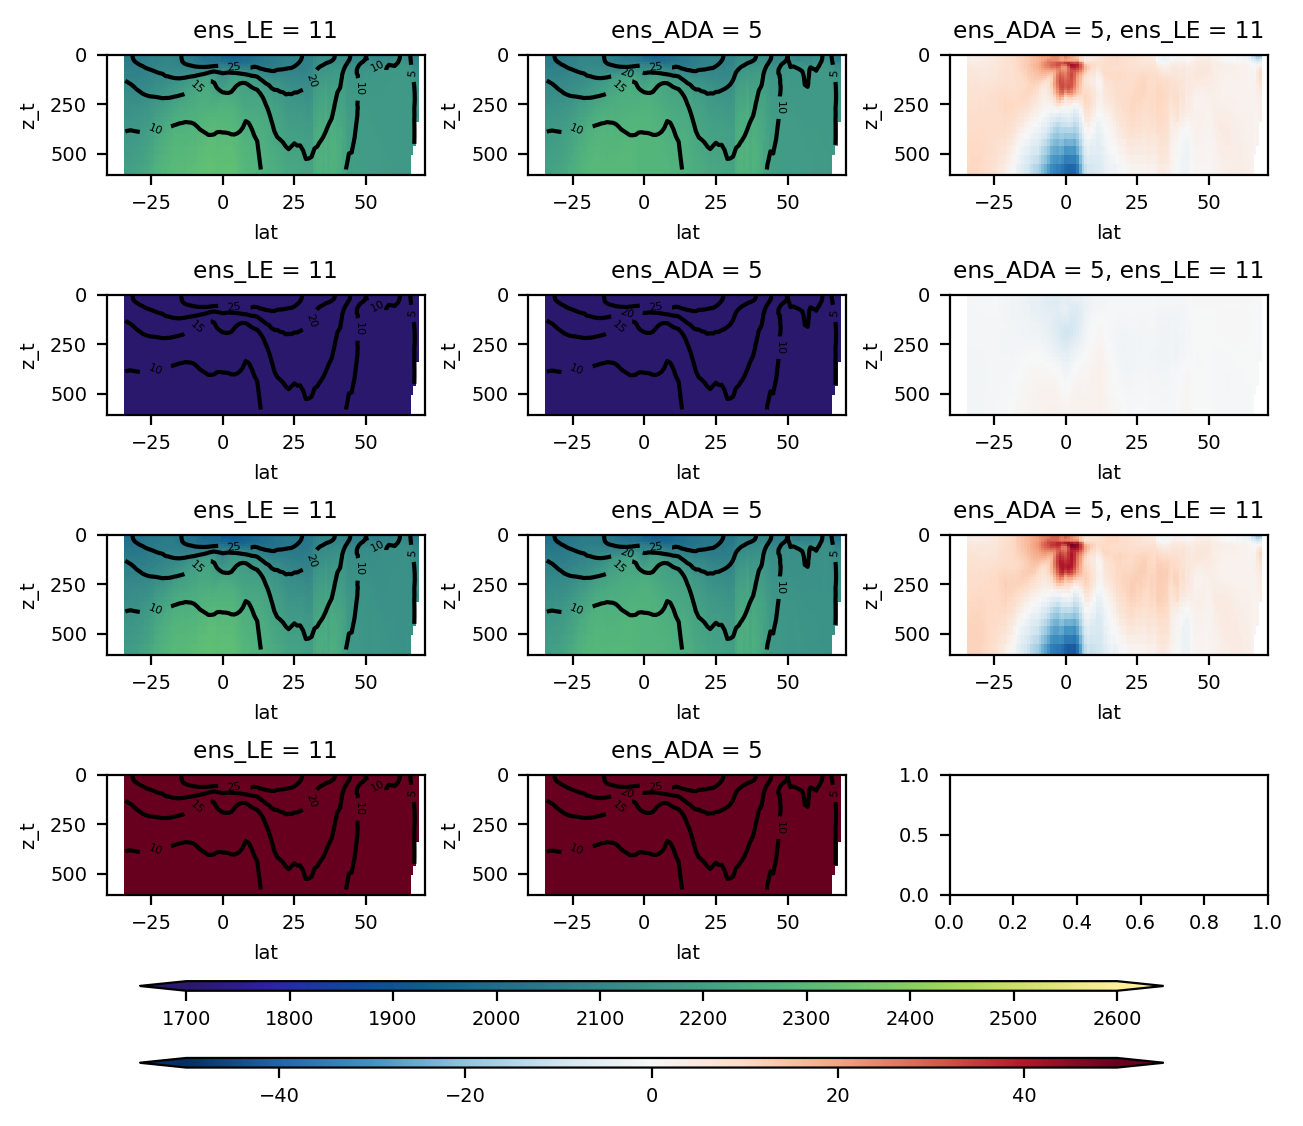

In [147]:
# 4*3 vertical section map (Atlantic longitudinal averaged)
# carbon storage changes (1994 - 1850(LE))

cmap = plt.get_cmap('nipy_spectral')
cmap.set_under("white")
cmap2 = plt.get_cmap('RdBu_r')
cmap3 =cmocean.cm.haline
fig, axes = plt.subplots(nrows=4, ncols=3, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)
contour_levels = [5, 10, 15, 20, 25, 30]

####################### DIC [0,0]   #######################
data_array=cfg_var_DIC_trop_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[0,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,0].invert_yaxis()


####################### DIC [0,1]   #######################
data_array=cfg_var_DIC_trop_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))


temp_array=cfg_var_TEMP_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[0,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,1].invert_yaxis()

####################### DIC [0,2]   #######################
data_array= cfg_var_DIC_trop_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_trop_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[0,2].invert_yaxis()


####################### DIC [1,0]   #######################
data_array=cfg_var_DIC_trop_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time') - cfg_var_DIC_ALT_trop_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[1,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,0].invert_yaxis()


####################### DIC [1,1]   #######################
data_array=cfg_var_DIC_trop_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[1,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,1].invert_yaxis()



####################### DIC [1,2]   #######################
data_array= ( cfg_var_DIC_trop_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time')
             - (cfg_var_DIC_trop_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time') - cfg_var_DIC_ALT_trop_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[1,2].invert_yaxis()


####################### DIC [2,0]   #######################
data_array=cfg_var_DIC_ALT_trop_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[2,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,0].invert_yaxis()


####################### DIC [2,1]   #######################
data_array=cfg_var_DIC_ALT_trop_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[2,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,1].invert_yaxis()



####################### DIC [2,2]   #######################
data_array= cfg_var_DIC_ALT_trop_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[2,2].invert_yaxis()


####################### DIC [3,0]   #######################
data_array= ( cfg_var_DIC_ALT_trop_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time') -
             (cfg_var_DIC_trop_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time') - cfg_var_DIC_ALT_trop_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[3,0], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[3,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,0].invert_yaxis()

####################### DIC [3,1]   #######################
data_array=( cfg_var_DIC_ALT_trop_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time') - 
            (cfg_var_DIC_trop_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time')))
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[3,1], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[3,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,1].invert_yaxis()


cbar_a_c = fig.add_axes([0.1, -0.02, 0.8, 0.01])  # [left, bottom, width, height]
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='horizontal', extend='both')
# cbar1.set_label('R')
cbar1.ax.tick_params(labelsize=7)
plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

cbar_a_c2 = fig.add_axes([0.1, -0.1, 0.8, 0.01])  # [left, bottom, width, height]
cbar2 = fig.colorbar(plt2, cax=cbar_a_c2, orientation='horizontal', extend='both')
cbar2.ax.tick_params(labelsize=7)


plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격
plt.rcParams.update({'font.size': 7})
plt.show()

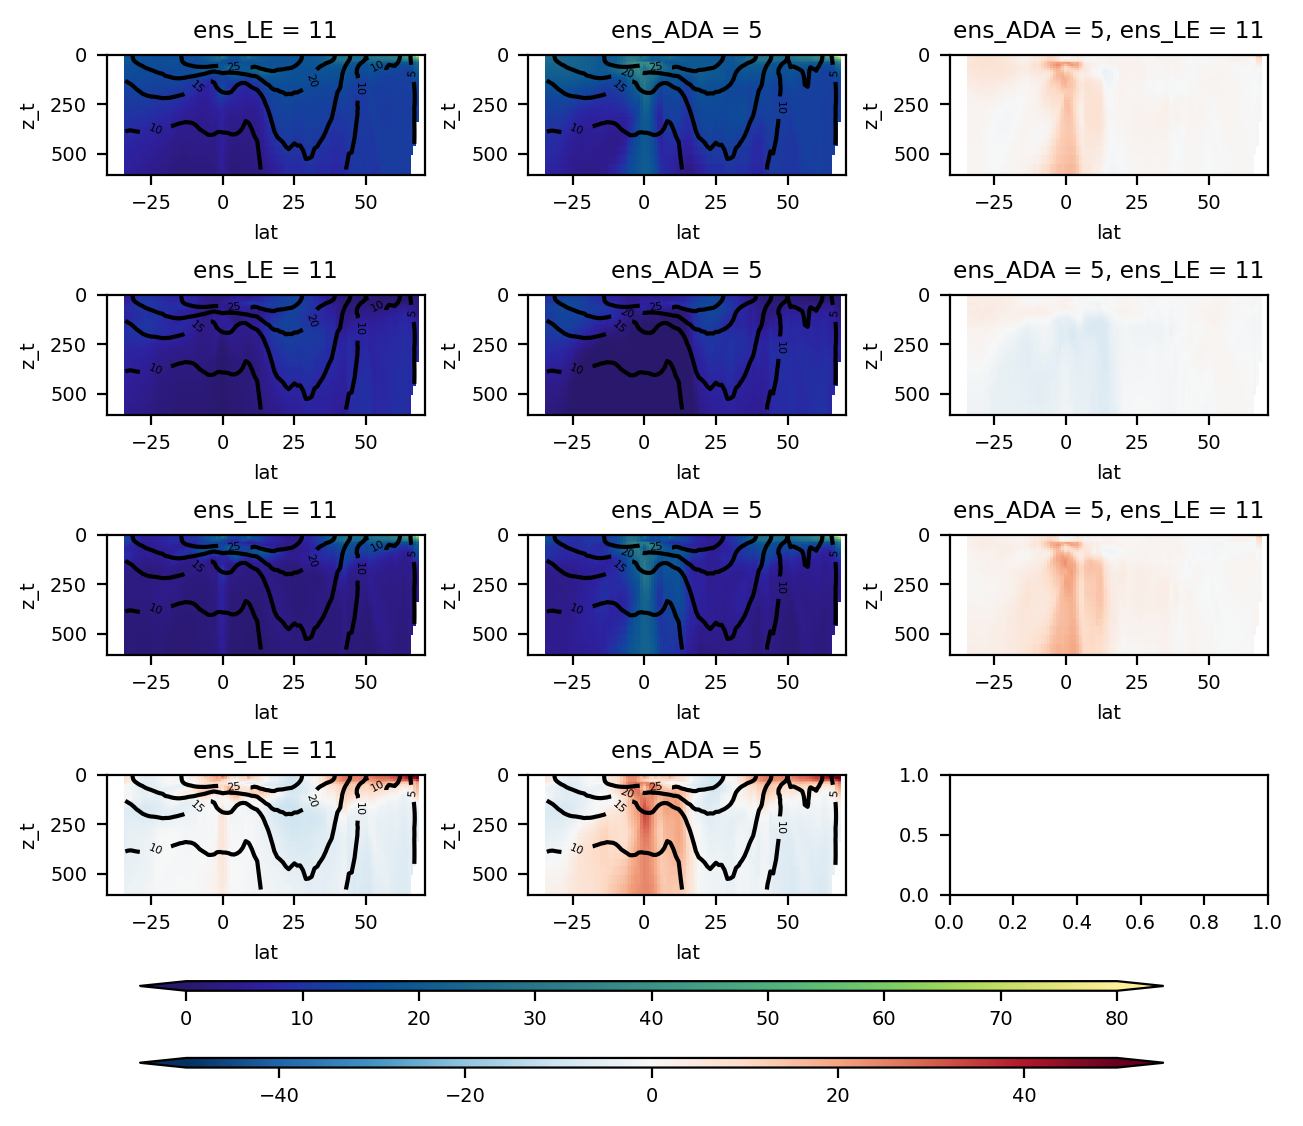

In [152]:
# 4*3 vertical section map (Atlantic std) 
# carbon storage changes (1994 - 1850(LE))

cmap = plt.get_cmap('nipy_spectral')
cmap.set_under("white")
cmap2 = plt.get_cmap('RdBu_r')
cmap3 =cmocean.cm.haline
fig, axes = plt.subplots(nrows=4, ncols=3, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)
contour_levels = [5, 10, 15, 20, 25, 30]

####################### DIC [0,0]   #######################
data_array=cfg_var_DIC_trop_atlantic.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[0,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,0].invert_yaxis()


####################### DIC [0,1]   #######################
data_array=cfg_var_DIC_trop_atlantic.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))


temp_array=cfg_var_TEMP_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[0,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,1].invert_yaxis()

####################### DIC [0,2]   #######################
data_array= cfg_var_DIC_trop_atlantic.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_trop_atlantic.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[0,2].invert_yaxis()


####################### DIC [1,0]   #######################
data_array=cfg_var_DIC_trop_atlantic.LE_ds.sel(ens_LE=11).std(dim='time') - cfg_var_DIC_ALT_trop_atlantic.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[1,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,0].invert_yaxis()


####################### DIC [1,1]   #######################
data_array=cfg_var_DIC_trop_atlantic.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop_atlantic.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[1,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,1].invert_yaxis()



####################### DIC [1,2]   #######################
data_array= ( cfg_var_DIC_trop_atlantic.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop_atlantic.ADA_ds.sel(ens_ADA=5).std(dim='time')
             - (cfg_var_DIC_trop_atlantic.LE_ds.sel(ens_LE=11).std(dim='time') - cfg_var_DIC_ALT_trop_atlantic.LE_ds.sel(ens_LE=11).std(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[1,2].invert_yaxis()


####################### DIC [2,0]   #######################
data_array=cfg_var_DIC_ALT_trop_atlantic.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[2,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,0].invert_yaxis()


####################### DIC [2,1]   #######################
data_array=cfg_var_DIC_ALT_trop_atlantic.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[2,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,1].invert_yaxis()



####################### DIC [2,2]   #######################
data_array= cfg_var_DIC_ALT_trop_atlantic.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop_atlantic.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[2,2].invert_yaxis()


####################### DIC [3,0]   #######################
data_array= ( cfg_var_DIC_ALT_trop_atlantic.LE_ds.sel(ens_LE=11).std(dim='time') -
             (cfg_var_DIC_trop_atlantic.LE_ds.sel(ens_LE=11).std(dim='time') - cfg_var_DIC_ALT_trop_atlantic.LE_ds.sel(ens_LE=11).std(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_atlantic.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[3,0], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[3,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,0].invert_yaxis()

####################### DIC [3,1]   #######################
data_array=( cfg_var_DIC_ALT_trop_atlantic.ADA_ds.sel(ens_ADA=5).std(dim='time') - 
            (cfg_var_DIC_trop_atlantic.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop_atlantic.ADA_ds.sel(ens_ADA=5).std(dim='time')))
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_atlantic.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[3,1], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[3,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,1].invert_yaxis()


cbar_a_c = fig.add_axes([0.1, -0.02, 0.8, 0.01])  # [left, bottom, width, height]
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='horizontal', extend='both')
# cbar1.set_label('R')
cbar1.ax.tick_params(labelsize=7)
plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

cbar_a_c2 = fig.add_axes([0.1, -0.1, 0.8, 0.01])  # [left, bottom, width, height]
cbar2 = fig.colorbar(plt2, cax=cbar_a_c2, orientation='horizontal', extend='both')
cbar2.ax.tick_params(labelsize=7)


plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격
plt.rcParams.update({'font.size': 7})
plt.show()

In [149]:
exceptcv2=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_DIC_trop.var, cfg_var_DIC_trop_ALT.var]

def process_coords_DIC_trop_indian(ds, sd, ed, mask_indian, drop=True, except_coord_vars=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_DIC_trop.var]):
    import xcesm 
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        ds = ds* mask_indian
        ds_rgd=ds.DIC.utils.regrid()
        # ds_rgd = ds_rgd.sel(lat=slice(-20,11))
        # ds_rgd = ds_rgd.where((ds_rgd.lon >= -50) | (ds_rgd.lon <= -50), drop=True).sum(dim='lon')/cell_area_2d.sum(dim='lon')
        ds_rgd = ds_rgd.sel(lat=slice(-40,70))
        ds_rgd = ds_rgd.where((ds_rgd.lon >= 30) & (ds_rgd.lon <= 150), drop=True)

        R = 6371e3  # Earth radius (m)
        deg2rad = np.pi / 180
        lat_radians = ds_rgd.lat * deg2rad
        cell_area_1d = R**2 * deg2rad * deg2rad * np.cos(lat_radians)
        cell_area_2d = cell_area_1d.broadcast_like(ds_rgd)
        mask_area=ds_rgd / ds_rgd
        cell_area_2d=cell_area_2d*mask_area
        ds_rgd = ds_rgd * cell_area_2d
        ds_rgd =ds_rgd .sum(dim='lon')/cell_area_2d.sum(dim='lon')
       
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)

def process_coords_DIC_ALT_trop_indian(ds, sd, ed, mask_indian, drop=True, except_coord_vars=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_DIC_trop_ALT.var]):
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        ds = ds* mask_indian
        ds_rgd=ds.DIC_ALT_CO2.utils.regrid()
        # ds_rgd = ds_rgd.sel(lat=slice(-20,11))
        # ds_rgd = ds_rgd.where((ds_rgd.lon >= -50) | (ds_rgd.lon <= -50), drop=True).sum(dim='lon')/cell_area_2d.sum(dim='lon')
        ds_rgd = ds_rgd.sel(lat=slice(-40,70))
        ds_rgd = ds_rgd.where((ds_rgd.lon >= 30) & (ds_rgd.lon <= 150), drop=True)

        R = 6371e3  # Earth radius (m)
        deg2rad = np.pi / 180
        lat_radians = ds_rgd.lat * deg2rad
        cell_area_1d = R**2 * deg2rad * deg2rad * np.cos(lat_radians)
        cell_area_2d = cell_area_1d.broadcast_like(ds_rgd)
        mask_area=ds_rgd / ds_rgd
        cell_area_2d=cell_area_2d*mask_area
        ds_rgd = ds_rgd * cell_area_2d
        ds_rgd =ds_rgd .sum(dim='lon')/cell_area_2d.sum(dim='lon')
       
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)


def process_coords_TEMP_indian(ds, sd, ed, mask_indian, drop=True, except_coord_vars=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', 'TEMP']):
    import xcesm 
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        ds = ds* mask_indian
        ds_rgd=ds.TEMP.utils.regrid()
        # ds_rgd = ds_rgd.sel(lat=slice(-20,11))
        # ds_rgd = ds_rgd.where((ds_rgd.lon >= -50) | (ds_rgd.lon <= -50), drop=True).sum(dim='lon')/cell_area_2d.sum(dim='lon')
        ds_rgd = ds_rgd.sel(lat=slice(-40,70))
        ds_rgd = ds_rgd.where((ds_rgd.lon >= 30) & (ds_rgd.lon <= 150), drop=True)

        R = 6371e3  # Earth radius (m)
        deg2rad = np.pi / 180
        lat_radians = ds_rgd.lat * deg2rad
        cell_area_1d = R**2 * deg2rad * deg2rad * np.cos(lat_radians)
        cell_area_2d = cell_area_1d.broadcast_like(ds_rgd)
        mask_area=ds_rgd / ds_rgd
        cell_area_2d=cell_area_2d*mask_area
        ds_rgd = ds_rgd * cell_area_2d
        ds_rgd =ds_rgd .sum(dim='lon')/cell_area_2d.sum(dim='lon')
       
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)

In [150]:
# DIC_trop - Indian

cfg_var_DIC_trop_indian=CESM2_config()
cfg_var_DIC_trop_indian.year_s=1955
cfg_var_DIC_trop_indian.year_e=2020
cfg_var_DIC_trop_indian.setvar('DIC')

cfg_var_TEMP_indian=CESM2_config()
cfg_var_TEMP_indian.year_s=1955
cfg_var_TEMP_indian.year_e=2020
cfg_var_TEMP_indian.setvar('TEMP')

cfg_var_DIC_ALT_trop_indian=CESM2_config()
cfg_var_DIC_ALT_trop_indian.year_s=1955
cfg_var_DIC_ALT_trop_indian.year_e=2020
cfg_var_DIC_ALT_trop_indian.setvar('DIC_ALT_CO2')

start_time = time.time()

cfg_var_DIC_trop_indian.LE_path_load(cfg_var_DIC_trop_indian.var)
cfg_var_DIC_trop_indian.LE_ds = xr.open_mfdataset(cfg_var_DIC_trop_indian.LE_file_list[0][11:13], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC_trop_indian.LE_ensembles[11:13]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_trop_indian(ds, start_date, end_date, mask_indian),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_trop_indian.LE_ds = cfg_var_DIC_trop_indian.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_DIC_trop_indian.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_trop_indian.LE_ds.time))
cfg_var_DIC_trop_indian.LE_ds = cfg_var_DIC_trop_indian.LE_ds.assign_coords(time=new_time)


cfg_var_DIC_trop_indian.ADA_path_load(cfg_var_DIC_trop_indian.var)
cfg_var_DIC_trop_indian.ADA_ds = xr.open_mfdataset(cfg_var_DIC_trop_indian.ADA_file_list[0][4:6], 
                       chunks={'time': 2}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_DIC_trop_indian.ADA_ensembles[4:6]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_trop_indian(ds, start_date, end_date, mask_indian),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_trop_indian.ADA_ds = cfg_var_DIC_trop_indian.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_DIC_trop_indian.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_trop_indian.ADA_ds.time))
cfg_var_DIC_trop_indian.ADA_ds = cfg_var_DIC_trop_indian.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading DIC_trop: ' + str(elapsed_time))


# DIC_ALT_trop

start_time = time.time()

cfg_var_DIC_ALT_trop_indian=CESM2_config()
cfg_var_DIC_ALT_trop_indian.year_s=1955
cfg_var_DIC_ALT_trop_indian.year_e=2020
cfg_var_DIC_ALT_trop_indian.setvar('DIC_ALT_CO2')

cfg_var_DIC_ALT_trop_indian.LE_path_load(cfg_var_DIC_ALT_trop_indian.var)
cfg_var_DIC_ALT_trop_indian.LE_ds = xr.open_mfdataset(cfg_var_DIC_ALT_trop_indian.LE_file_list[0][11:13], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_DIC_ALT_trop_indian.LE_ensembles[11:13]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_ALT_trop_indian(ds, start_date, end_date, mask_indian),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_ALT_trop_indian.LE_ds = cfg_var_DIC_ALT_trop_indian.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_DIC_ALT_trop_indian.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_ALT_trop_indian.LE_ds.time))
cfg_var_DIC_ALT_trop_indian.LE_ds = cfg_var_DIC_ALT_trop_indian.LE_ds.assign_coords(time=new_time)


cfg_var_DIC_ALT_trop_indian.ADA_path_load(cfg_var_DIC_ALT_trop_indian.var)
cfg_var_DIC_ALT_trop_indian.ADA_ds = xr.open_mfdataset(cfg_var_DIC_ALT_trop_indian.ADA_file_list[0][4:6], 
                       chunks={'time': 2}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_DIC_ALT_trop_indian.ADA_ensembles[4:6]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_DIC_ALT_trop_indian(ds, start_date, end_date, mask_indian),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_DIC_ALT_trop_indian.ADA_ds = cfg_var_DIC_ALT_trop_indian.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_DIC_ALT_trop_indian.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_DIC_ALT_trop_indian.ADA_ds.time))
cfg_var_DIC_ALT_trop_indian.ADA_ds = cfg_var_DIC_ALT_trop_indian.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading DIC_ALT_trop: ' + str(elapsed_time))

# TEMP

start_time = time.time()

cfg_var_TEMP_indian.LE_path_load(cfg_var_TEMP_indian.var)
cfg_var_TEMP_indian.LE_ds = xr.open_mfdataset(cfg_var_TEMP_indian.LE_file_list[0][11:13], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP_indian.LE_ensembles[11:13]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_TEMP_indian(ds, start_date, end_date, mask_indian),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TEMP_indian.LE_ds = cfg_var_TEMP_indian.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_TEMP_indian.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP_indian.LE_ds.time))
cfg_var_TEMP_indian.LE_ds = cfg_var_TEMP_indian.LE_ds.assign_coords(time=new_time)


cfg_var_TEMP_indian.ADA_path_load(cfg_var_TEMP_indian.var)
cfg_var_TEMP_indian.ADA_ds = xr.open_mfdataset(cfg_var_TEMP_indian.ADA_file_list[0][4:6], 
                       chunks={'time': 2}, 
                       combine='nested',
                       concat_dim=[[*cfg_var_TEMP_indian.ADA_ensembles[4:6]], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_TEMP_indian(ds, start_date, end_date, mask_indian),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TEMP_indian.ADA_ds = cfg_var_TEMP_indian.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_TEMP_indian.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP_indian.ADA_ds.time))
cfg_var_TEMP_indian.ADA_ds = cfg_var_TEMP_indian.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading TEMP: ' + str(elapsed_time))

elasped time for reading DIC_trop: 303.8594534397125
elasped time for reading DIC_ALT_trop: 397.70167422294617
elasped time for reading TEMP: 266.46519660949707


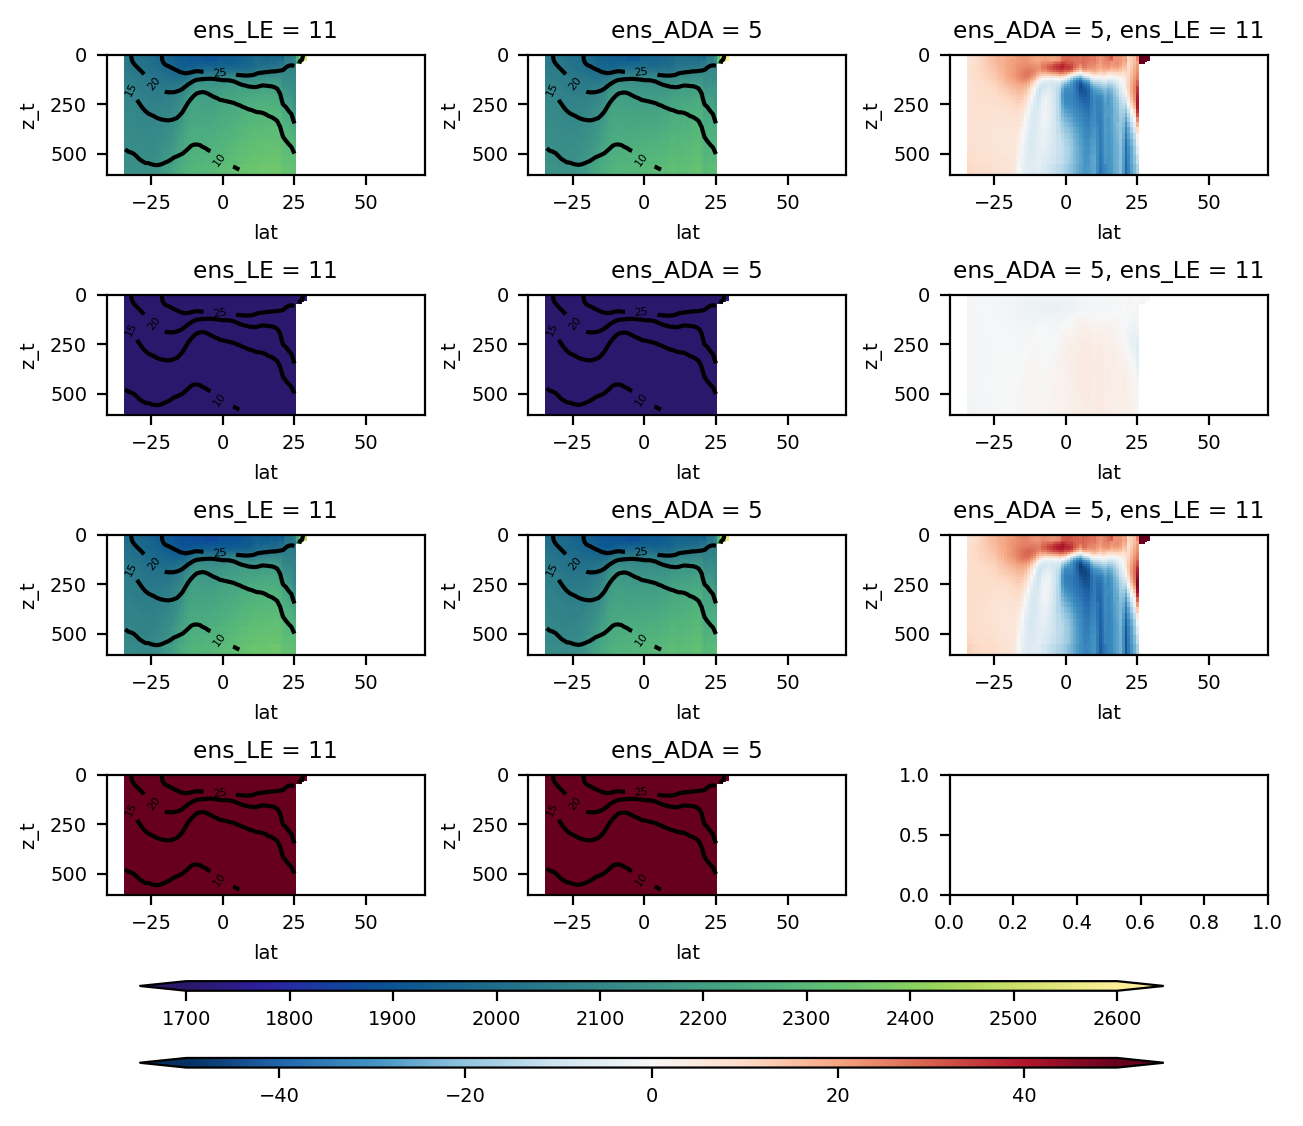

In [153]:
# 4*3 vertical section map (indian longitudinal averaged)
# carbon storage changes (1994 - 1850(LE))

cmap = plt.get_cmap('nipy_spectral')
cmap.set_under("white")
cmap2 = plt.get_cmap('RdBu_r')
cmap3 =cmocean.cm.haline
fig, axes = plt.subplots(nrows=4, ncols=3, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)
contour_levels = [5, 10, 15, 20, 25, 30]

####################### DIC [0,0]   #######################
data_array=cfg_var_DIC_trop_indian.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_indian.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[0,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,0].invert_yaxis()


####################### DIC [0,1]   #######################
data_array=cfg_var_DIC_trop_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))


temp_array=cfg_var_TEMP_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[0,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,1].invert_yaxis()

####################### DIC [0,2]   #######################
data_array= cfg_var_DIC_trop_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_trop_indian.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[0,2].invert_yaxis()


####################### DIC [1,0]   #######################
data_array=cfg_var_DIC_trop_indian.LE_ds.sel(ens_LE=11).mean(dim='time') - cfg_var_DIC_ALT_trop_indian.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_indian.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[1,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,0].invert_yaxis()


####################### DIC [1,1]   #######################
data_array=cfg_var_DIC_trop_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[1,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,1].invert_yaxis()



####################### DIC [1,2]   #######################
data_array= ( cfg_var_DIC_trop_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time')
             - (cfg_var_DIC_trop_indian.LE_ds.sel(ens_LE=11).mean(dim='time') - cfg_var_DIC_ALT_trop_indian.LE_ds.sel(ens_LE=11).mean(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[1,2].invert_yaxis()


####################### DIC [2,0]   #######################
data_array=cfg_var_DIC_ALT_trop_indian.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_indian.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[2,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,0].invert_yaxis()


####################### DIC [2,1]   #######################
data_array=cfg_var_DIC_ALT_trop_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=1700, vmax=2600, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[2,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,1].invert_yaxis()



####################### DIC [2,2]   #######################
data_array= cfg_var_DIC_ALT_trop_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop_indian.LE_ds.sel(ens_LE=11).mean(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[2,2].invert_yaxis()


####################### DIC [3,0]   #######################
data_array= ( cfg_var_DIC_ALT_trop_indian.LE_ds.sel(ens_LE=11).mean(dim='time') -
             (cfg_var_DIC_trop_indian.LE_ds.sel(ens_LE=11).mean(dim='time') - cfg_var_DIC_ALT_trop_indian.LE_ds.sel(ens_LE=11).mean(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_indian.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[3,0], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[3,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,0].invert_yaxis()

####################### DIC [3,1]   #######################
data_array=( cfg_var_DIC_ALT_trop_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time') - 
            (cfg_var_DIC_trop_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time') - cfg_var_DIC_ALT_trop_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time')))
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[3,1], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[3,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,1].invert_yaxis()


cbar_a_c = fig.add_axes([0.1, -0.02, 0.8, 0.01])  # [left, bottom, width, height]
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='horizontal', extend='both')
# cbar1.set_label('R')
cbar1.ax.tick_params(labelsize=7)
plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

cbar_a_c2 = fig.add_axes([0.1, -0.1, 0.8, 0.01])  # [left, bottom, width, height]
cbar2 = fig.colorbar(plt2, cax=cbar_a_c2, orientation='horizontal', extend='both')
cbar2.ax.tick_params(labelsize=7)


plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격
plt.rcParams.update({'font.size': 7})
plt.show()

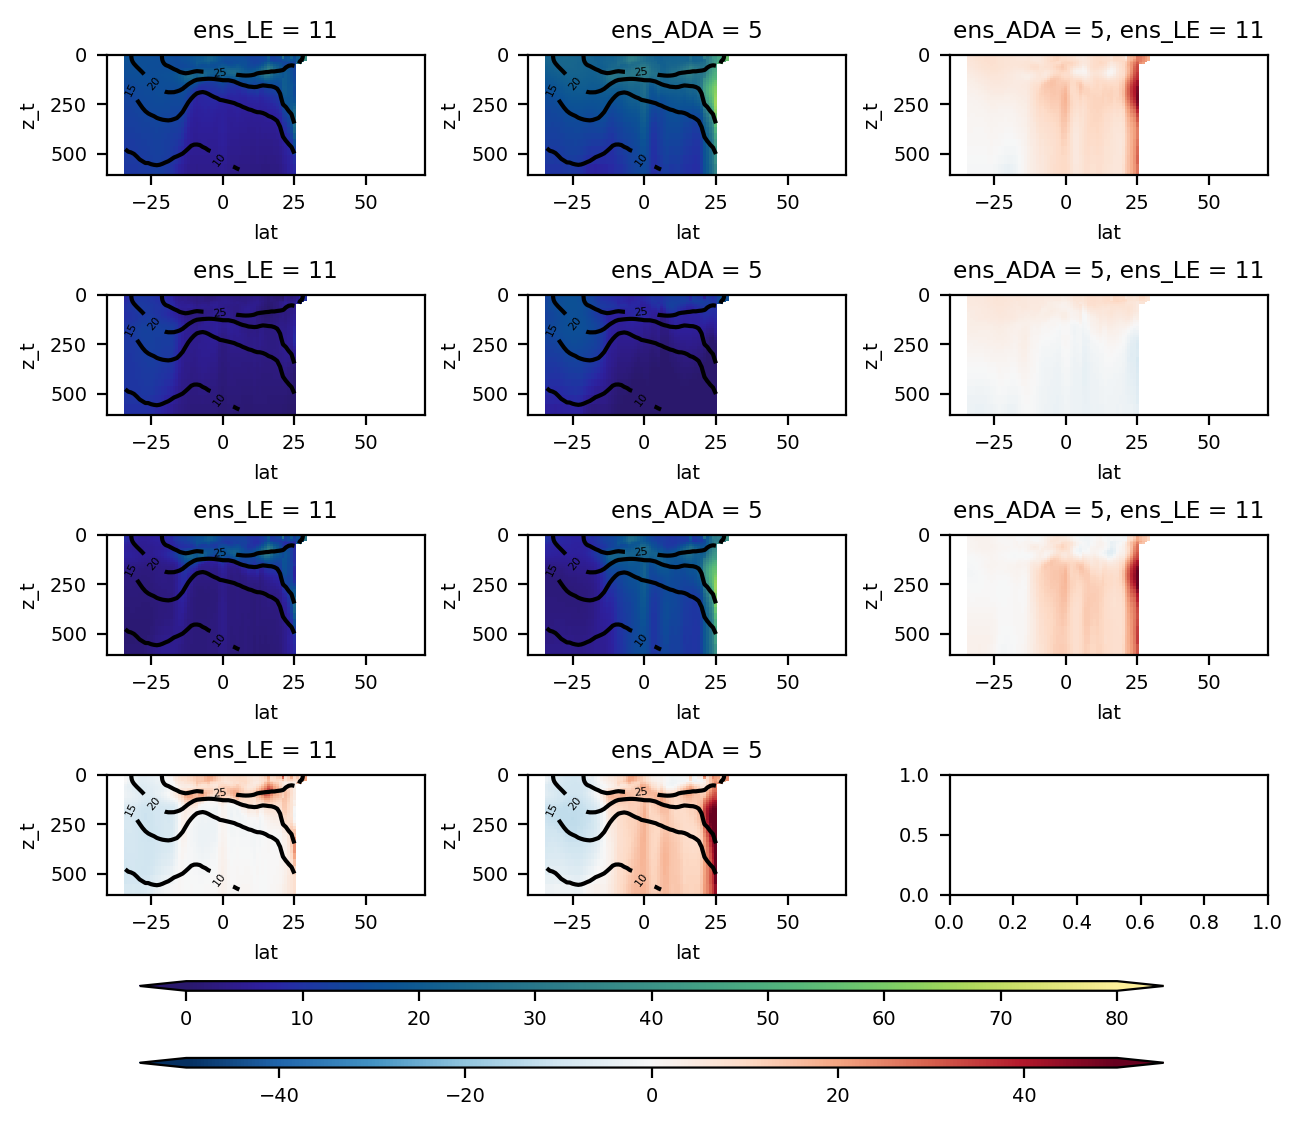

In [154]:
# 4*3 vertical section map (indian std) 
# carbon storage changes (1994 - 1850(LE))

cmap = plt.get_cmap('nipy_spectral')
cmap.set_under("white")
cmap2 = plt.get_cmap('RdBu_r')
cmap3 =cmocean.cm.haline
fig, axes = plt.subplots(nrows=4, ncols=3, 
             dpi=200, facecolor='w', edgecolor='k', constrained_layout=True)
contour_levels = [5, 10, 15, 20, 25, 30]

####################### DIC [0,0]   #######################
data_array=cfg_var_DIC_trop_indian.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_indian.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[0,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,0].invert_yaxis()


####################### DIC [0,1]   #######################
data_array=cfg_var_DIC_trop_indian.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))


temp_array=cfg_var_TEMP_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[0,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[0,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[0,1].invert_yaxis()

####################### DIC [0,2]   #######################
data_array= cfg_var_DIC_trop_indian.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_trop_indian.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[0,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[0,2].invert_yaxis()


####################### DIC [1,0]   #######################
data_array=cfg_var_DIC_trop_indian.LE_ds.sel(ens_LE=11).std(dim='time') - cfg_var_DIC_ALT_trop_indian.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_indian.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[1,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,0].invert_yaxis()


####################### DIC [1,1]   #######################
data_array=cfg_var_DIC_trop_indian.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop_indian.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[1,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[1,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[1,1].invert_yaxis()



####################### DIC [1,2]   #######################
data_array= ( cfg_var_DIC_trop_indian.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop_indian.ADA_ds.sel(ens_ADA=5).std(dim='time')
             - (cfg_var_DIC_trop_indian.LE_ds.sel(ens_LE=11).std(dim='time') - cfg_var_DIC_ALT_trop_indian.LE_ds.sel(ens_LE=11).std(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[1,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[1,2].invert_yaxis()


####################### DIC [2,0]   #######################
data_array=cfg_var_DIC_ALT_trop_indian.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_indian.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,0], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[2,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,0].invert_yaxis()


####################### DIC [2,1]   #######################
data_array=cfg_var_DIC_ALT_trop_indian.ADA_ds.sel(ens_ADA=5).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt1=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,1], cmap= cmap3, add_colorbar=False, 
                                  vmin=0, vmax=80, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[2,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[2,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[2,1].invert_yaxis()



####################### DIC [2,2]   #######################
data_array= cfg_var_DIC_ALT_trop_indian.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop_indian.LE_ds.sel(ens_LE=11).std(dim='time')
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[2,2], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')
axes[2,2].invert_yaxis()


####################### DIC [3,0]   #######################
data_array= ( cfg_var_DIC_ALT_trop_indian.LE_ds.sel(ens_LE=11).std(dim='time') -
             (cfg_var_DIC_trop_indian.LE_ds.sel(ens_LE=11).std(dim='time') - cfg_var_DIC_ALT_trop_indian.LE_ds.sel(ens_LE=11).std(dim='time')) )
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_indian.LE_ds.sel(ens_LE=11).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[3,0], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[3,0], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,0].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,0].invert_yaxis()

####################### DIC [3,1]   #######################
data_array=( cfg_var_DIC_ALT_trop_indian.ADA_ds.sel(ens_ADA=5).std(dim='time') - 
            (cfg_var_DIC_trop_indian.ADA_ds.sel(ens_ADA=5).std(dim='time') - cfg_var_DIC_ALT_trop_indian.ADA_ds.sel(ens_ADA=5).std(dim='time')))
data_array['z_t']=ds_grid.z_t/100
data_array=data_array.isel(z_t=slice(0,35))

temp_array=cfg_var_TEMP_indian.ADA_ds.sel(ens_ADA=5).mean(dim='time')
temp_array['z_t']=ds_grid.z_t/100
temp_array=temp_array.isel(z_t=slice(0,35))

plt2=data_array.plot.pcolormesh(x='lat', y='z_t', ax=axes[3,1], cmap= cmap2, add_colorbar=False, 
                                  vmin=-50, vmax=50, extend='both')

cs = temp_array.plot.contour(
    x='lat', y='z_t', ax=axes[3,1], colors='black',
    levels=contour_levels, linewidths=1.5,
    add_colorbar=False
)
axes[3,1].clabel(cs, inline=True, inline_spacing=8, fontsize=4)
axes[3,1].invert_yaxis()


cbar_a_c = fig.add_axes([0.1, -0.02, 0.8, 0.01])  # [left, bottom, width, height]
cbar1 = fig.colorbar(plt1, cax=cbar_a_c, orientation='horizontal', extend='both')
# cbar1.set_label('R')
cbar1.ax.tick_params(labelsize=7)
plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격

cbar_a_c2 = fig.add_axes([0.1, -0.1, 0.8, 0.01])  # [left, bottom, width, height]
cbar2 = fig.colorbar(plt2, cax=cbar_a_c2, orientation='horizontal', extend='both')
cbar2.ax.tick_params(labelsize=7)


plt.subplots_adjust(hspace=0.3, wspace=0.05)  # hspace: 세로 간격, wspace: 가로 간격
plt.rcParams.update({'font.size': 7})
plt.show()